In [100]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [101]:
# Run this cell to start a spark session in this notebook

#start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)

start_spark(executor_instances=8, executor_cores=8, worker_memory=4, master_memory=8)

#start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/hwa185/spark/
spark.driver.port,40755
spark.sql.warehouse.dir,file:/users/home/hwa185/spark-warehouse
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.executor.instances,8
spark.app.id,app-20240516151432-1235
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.ui.port,4433


In [3]:
# Write your imports and code here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *

# Data processing

# Q1

## (b)

### Main data

In [4]:
meta_data = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .load("hdfs:///data/msd/main/summary/metadata.csv.gz")
)
meta_data.show()
meta_data.count()

+----------------+-----------------+-------------------+-------------------+------------------+---------------+--------------------+----------------+--------------------+--------------------+---------------+-----+----------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------+----------------+
|analyzer_version|artist_7digitalid| artist_familiarity|  artist_hotttnesss|         artist_id|artist_latitude|     artist_location|artist_longitude|         artist_mbid|         artist_name|artist_playmeid|genre|idx_artist_terms|idx_similar_artists|             release|release_7digitalid|    song_hotttnesss|           song_id|               title|track_7digitalid|
+----------------+-----------------+-------------------+-------------------+------------------+---------------+--------------------+----------------+--------------------+--------------------+---------------+-----+----------------+-------------------+--------------

1000000

In [5]:
analysis_data = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .load("hdfs:///data/msd/main/summary/analysis.csv.gz")
)

analysis_data.show()
analysis_data.count()

#/data/msd/main/summary/analysis.csv.gz

+--------------------+--------------------+------------+---------+--------------+------+-------------------+--------------+--------------------+---------------+-----------------------+------------------+-----------------------+-------------------------+------------------------------+---------------------------+--------------------+------------------+-------------------+---------------------+----------------+---+--------------+--------+----+---------------+-----------------+-------+--------------+-------------------------+------------------+
|analysis_sample_rate|           audio_md5|danceability| duration|end_of_fade_in|energy|idx_bars_confidence|idx_bars_start|idx_beats_confidence|idx_beats_start|idx_sections_confidence|idx_sections_start|idx_segments_confidence|idx_segments_loudness_max|idx_segments_loudness_max_time|idx_segments_loudness_start|idx_segments_pitches|idx_segments_start|idx_segments_timbre|idx_tatums_confidence|idx_tatums_start|key|key_confidence|loudness|mode|mode_conf

1000000

### Taste Profiles

In [6]:
mismaches = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .load("hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt")
)

mismaches.show()
mismaches.count()
#/data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt

+--------------------+
|                 _c0|
+--------------------+
|                 9d8|
|< ERROR: <SOFQHZM...|
|               19d17|
|< ERROR: <SODXUTF...|
|               29d26|
|< ERROR: <SOASCRF...|
|               33d29|
|< ERROR: <SOITDUN...|
|               52d47|
|< ERROR: <SOLZXUM...|
|             126d120|
|< ERROR: <SOTJTDT...|
|             153d146|
|< ERROR: <SOGCVWB...|
|             230d222|
|< ERROR: <SOKDKGD...|
|             235d226|
|< ERROR: <SOPPBXP...|
|             276d266|
|< ERROR: <SODQSLR...|
+--------------------+
only showing top 20 rows



938

In [7]:
sid_mismaches = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .load("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")
)

sid_mismaches.show()
sid_mismaches.count()

#/data/msd/tasteprofile/mismatches/sid_mismatches.txt 

+--------------------+
|                 _c0|
+--------------------+
|ERROR: <SOUMNSI12...|
|ERROR: <SOCMRBE12...|
|ERROR: <SOLPHZY12...|
|ERROR: <SONGHTM12...|
|ERROR: <SONGXCA12...|
|ERROR: <SOMBCRC12...|
|ERROR: <SOTDWDK12...|
|ERROR: <SOEBURP12...|
|ERROR: <SOSRJHS12...|
|ERROR: <SOIYAAQ12...|
|ERROR: <SOUQUOG12...|
|ERROR: <SORRXFX12...|
|ERROR: <SOBWQMY12...|
|ERROR: <SOCYTXQ12...|
|ERROR: <SOKMSQN12...|
|ERROR: <SOFXDWK12...|
|ERROR: <SOBPEIN12...|
|ERROR: <SOANRSQ12...|
|ERROR: <SOVWUNG12...|
|ERROR: <SOOBZPE12...|
+--------------------+
only showing top 20 rows



19094

In [8]:
file_path = [
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00000.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00001.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00002.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00003.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00004.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00005.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00006.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00007.tsv.gz"]

In [9]:
file_path = [
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00000.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00001.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00002.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00003.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00004.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00005.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00006.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00007.tsv.gz"]

triplets = spark.read.csv(file_path, sep='\t', header=False)
triplets.show()
triplets.count()

+--------------------+------------------+---+
|                 _c0|               _c1|_c2|
+--------------------+------------------+---+
|f1bfc2a4597a3642f...|SOQEFDN12AB017C52B|  1|
|f1bfc2a4597a3642f...|SOQOIUJ12A6701DAA7|  2|
|f1bfc2a4597a3642f...|SOQOKKD12A6701F92E|  4|
|f1bfc2a4597a3642f...|SOSDVHO12AB01882C7|  1|
|f1bfc2a4597a3642f...|SOSKICX12A6701F932|  1|
|f1bfc2a4597a3642f...|SOSNUPV12A8C13939B|  1|
|f1bfc2a4597a3642f...|SOSVMII12A6701F92D|  1|
|f1bfc2a4597a3642f...|SOTUNHI12B0B80AFE2|  1|
|f1bfc2a4597a3642f...|SOTXLTZ12AB017C535|  1|
|f1bfc2a4597a3642f...|SOTZDDX12A6701F935|  1|
|f1bfc2a4597a3642f...|SOTZTVF12A58A79B9F|  1|
|f1bfc2a4597a3642f...|SOUGTZZ12A8C13B8CC|  1|
|f1bfc2a4597a3642f...|SOVDLVW12A6701F92F|  1|
|f1bfc2a4597a3642f...|SOVKHBC12AF72A5DE7|  1|
|f1bfc2a4597a3642f...|SOVKJMM12AF72AAF3C|  1|
|f1bfc2a4597a3642f...|SOVMWUC12A8C13750B|  1|
|f1bfc2a4597a3642f...|SOVQPUM12A6D4F8F18|  1|
|f1bfc2a4597a3642f...|SOVVTJV12AB017B20E|  1|
|f1bfc2a4597a3642f...|SOXREWC12A6D

48373586

### Audio

#### attributes

In [10]:
#/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv                       
#/data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv                                   
#/data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv                    
#/data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv                                  
#/data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv                          
#/data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv              
#/data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv                               
#/data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv                                            
#/data/msd/audio/attributes/msd-rh-v1.0.attributes.csv                                             
#/data/msd/audio/attributes/msd-rp-v1.0.attributes.csv                                             
#/data/msd/audio/attributes/msd-ssd-v1.0.attributes.csv
#/data/msd/audio/attributes/msd-trh-v1.0.attributes.csv 
#/data/msd/audio/attributes/msd-tssd-v1.0.attributes.csv 

### features

#### msd-jmir-area-of-moments-all-v1.0.csv

In [11]:
path = ["hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00000.csv.gz",
       "hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00001.csv.gz",
       "hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00002.csv.gz",
       "hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00003.csv.gz",
       "hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00004.csv.gz",
       "hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00005.csv.gz",
       "hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00006.csv.gz",
       "hdfs:///data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00007.csv.gz"]

In [12]:
jmir_area = spark.read.csv(path, sep='\t', header=False)
jmir_area.show(truncate = False)
jmir_area.count()

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_c0                                                                                                                                                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1.2,3355.0,26270.0,39850000.0,309600000.0,2403000000.0,8.749e+11,2775000000.0,21550000000.0,4.064e+14,3.201,5746.0,43470.0,-44220000.0,-337600000.0,-2576000000.0,7.665e+11,3015000000.0,23020000000.0,3.46e+14,'TRHFHQZ12903C9E2D5'          |
|0.9295,6720.0,44100.0,160800000.0,1

994623

#### msd-jmir-lpc-all-v1.0

In [13]:
path0 = ["hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-00007.csv.gz"]

In [14]:
jmir_lpc = spark.read.csv(path, sep='\t', header=False)
jmir_lpc.show()
jmir_lpc.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-jmir-methods-of-moments-all-v1.0

In [15]:
path1 = ["hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-00007.csv.gz"]

In [16]:
jmir_methods = spark.read.csv(path, sep='\t', header=False)
jmir_methods.show()
jmir_methods.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-jmir-mfcc-all-v1.0

In [105]:
path2 = ["hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-00007.csv.gz"]

In [18]:
msd_jmir = spark.read.csv(path, sep='\t', header=False)
msd_jmir.show()
msd_jmir.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-jmir-spectral-all-all-v1.0

In [19]:
path3 = ["hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-00007.csv.gz"]

In [20]:
msd_jmir = spark.read.csv(path, sep='\t', header=False)
msd_jmir.show()
msd_jmir.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-jmir-spectral-derivatives-all-all-v1.0

In [21]:
path4 = ["hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-00007.csv.gz"]

In [22]:
msd_jmir_derivatives = spark.read.csv(path, sep='\t', header=False)
msd_jmir_derivatives.show()
msd_jmir_derivatives.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-marsyas-timbral-v1.0

In [23]:
path5 = ["hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-00007.csv.gz"]

In [24]:
msd_marsyas = spark.read.csv(path, sep='\t', header=False)
msd_marsyas.show()
msd_marsyas.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-mvd-v1.0

In [25]:
path6 = ["hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-mvd-v1.0.csv/part-00007.csv.gz"]

In [26]:
msd_mvd = spark.read.csv(path, sep='\t', header=False)
msd_mvd.show()
msd_mvd.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-rh-v1.0

In [27]:
path7 = ["hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rh-v1.0.csv/part-00007.csv.gz"]

In [28]:
msd_rh = spark.read.csv(path, sep='\t', header=False)
msd_rh.show()
msd_rh.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-rp-v1.0

In [29]:
path8 = ["hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-rp-v1.0.csv/part-00007.csv.gz"]

In [30]:
msd_rp = spark.read.csv(path, sep='\t', header=False)
msd_rp.show(truncate = False)
msd_rp.count()

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_c0                                                                                                                                                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1.2,3355.0,26270.0,39850000.0,309600000.0,2403000000.0,8.749e+11,2775000000.0,21550000000.0,4.064e+14,3.201,5746.0,43470.0,-44220000.0,-337600000.0,-2576000000.0,7.665e+11,3015000000.0,23020000000.0,3.46e+14,'TRHFHQZ12903C9E2D5'          |
|0.9295,6720.0,44100.0,160800000.0,1

994623

#### msd-ssd-v1.0

In [31]:
path9 = ["hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-ssd-v1.0.csv/part-00007.csv.gz"]

In [32]:
msd_ssd = spark.read.csv(path, sep='\t', header=False)
msd_ssd.show()
msd_ssd.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-trh-v1.0

In [33]:
path10 = ["hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-trh-v1.0.csv/part-00007.csv.gz"]

In [34]:
msd_trh = spark.read.csv(path, sep='\t', header=False)
msd_trh.show()
msd_trh.count()

+--------------------+
|                 _c0|
+--------------------+
|1.2,3355.0,26270....|
|0.9295,6720.0,441...|
|1.883,6712.0,4906...|
|1.884,6722.0,5613...|
|1.52,6709.0,53230...|
|1.363,6710.0,2875...|
|0.8262,3355.0,173...|
|0.7786,6717.0,353...|
|0.7986,6712.0,212...|
|1.778,6735.0,4954...|
|2.191,6742.0,5468...|
|1.106,1956.0,1644...|
|1.702,3354.0,2152...|
|1.3,6717.0,35630....|
|1.295,6710.0,4646...|
|0.4827,6723.0,603...|
|1.511,6715.0,4665...|
|1.395,3357.0,1442...|
|2.1,3356.0,25760....|
|0.6198,6712.0,298...|
+--------------------+
only showing top 20 rows



994623

#### msd-tssd-v1.0

In [35]:
path11 = ["hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/part-00000.csv.gz",
        "hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/part-00001.csv.gz",
        "hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/part-00002.csv.gz",
        "hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/part-00003.csv.gz",
        "hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/part-00004.csv.gz",
        "hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/part-00005.csv.gz",
        "hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/part-00006.csv.gz",
        "hdfs:///data/msd/audio/features/msd-tssd-v1.0.csv/part-00007.csv.gz"]

In [36]:
msd_tssd = spark.read.csv(path, sep='\t', header=False)
msd_tssd.show(truncate = False)
msd_tssd.count()

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_c0                                                                                                                                                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1.2,3355.0,26270.0,39850000.0,309600000.0,2403000000.0,8.749e+11,2775000000.0,21550000000.0,4.064e+14,3.201,5746.0,43470.0,-44220000.0,-337600000.0,-2576000000.0,7.665e+11,3015000000.0,23020000000.0,3.46e+14,'TRHFHQZ12903C9E2D5'          |
|0.9295,6720.0,44100.0,160800000.0,1

994623

### statistics

#### sample_properties

In [37]:
statistics = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "true")
    .option("inferSchema", "false")
    .load("hdfs:///data/msd/audio/statistics/sample_properties.csv.gz")
)
statistics.show()
statistics.count()

+------------------+--------------------+--------------------+---------+----------+--------------+-------------+-----------+-----------+--------------+--------+
|          track_id|               title|         artist_name| duration|7digita_Id|sample_bitrate|sample_length|sample_rate|sample_mode|sample_version|filesize|
+------------------+--------------------+--------------------+---------+----------+--------------+-------------+-----------+-----------+--------------+--------+
|TRMMMYQ128F932D901|        Silent Night|    Faster Pussy cat|252.05506|   7032331|           128|60.1935770567|      22050|          1|             2|  960887|
|TRMMMKD128F425225D|         Tanssi vaan|    Karkkiautomaatti|156.55138|   1514808|            64|30.2244270016|      22050|          1|             2|  242038|
|TRMMMRX128F93187D9|   No One Could Ever|      Hudson Mohawke|138.97098|   6945353|           128|60.1935770567|      22050|          1|             2|  960887|
|TRMMMCH128F425532C|       Si Vos 

992865

## genre

### msd-MAGD-genreAssignment

In [38]:
genre = (
    spark.read.format("csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .option("delimiter", "\t")  # Specify the delimiter as tab
    .load("hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv")
)

genre.show(truncate=False)
genre.count()

+------------------+--------------+
|_c0               |_c1           |
+------------------+--------------+
|TRAAAAK128F9318786|Pop_Rock      |
|TRAAAAV128F421A322|Pop_Rock      |
|TRAAAAW128F429D538|Rap           |
|TRAAABD128F429CF47|Pop_Rock      |
|TRAAACV128F423E09E|Pop_Rock      |
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|Vocal         |
|TRAAAEF128F4273421|Pop_Rock      |
|TRAAAEM128F93347B9|Electronic    |
|TRAAAFD128F92F423A|Pop_Rock      |
|TRAAAFP128F931B4E3|Rap           |
|TRAAAGR128F425B14B|Pop_Rock      |
|TRAAAGW12903CC1049|Blues         |
|TRAAAHD128F42635A5|Pop_Rock      |
|TRAAAHE12903C9669C|Pop_Rock      |
|TRAAAHJ128F931194C|Pop_Rock      |
|TRAAAHZ128E0799171|Rap           |
|TRAAAIR128F1480971|RnB           |
|TRAAAJG128F9308A25|Folk          |
|TRAAAMO128F1481E7F|Religious     |
+------------------+--------------+
only showing top 20 rows



422714

### msd-MASD-styleAssignment

In [39]:
style = (
    spark.read.format("csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .option("delimiter", "\t")  # Specify the delimiter as tab
    .load("hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv")
)

style.show()
style.count()

+------------------+--------------------+
|               _c0|                 _c1|
+------------------+--------------------+
|TRAAAAK128F9318786|   Metal_Alternative|
|TRAAAAV128F421A322|                Punk|
|TRAAAAW128F429D538|         Hip_Hop_Rap|
|TRAAACV128F423E09E|Rock_Neo_Psychedelia|
|TRAAAEF128F4273421|           Pop_Indie|
|TRAAAFP128F931B4E3|         Hip_Hop_Rap|
|TRAAAGR128F425B14B|    Pop_Contemporary|
|TRAAAHD128F42635A5|           Rock_Hard|
|TRAAAHJ128F931194C|           Pop_Indie|
|TRAAAHZ128E0799171|         Hip_Hop_Rap|
|TRAAAIR128F1480971|    Pop_Contemporary|
|TRAAAJG128F9308A25| Country_Traditional|
|TRAAAMO128F1481E7F|              Gospel|
|TRAAAMQ128F1460CD3|         Hip_Hop_Rap|
|TRAAANK128F428B515|Rock_Neo_Psychedelia|
|TRAAARJ128F9320760|    Pop_Contemporary|
|TRAAAVO128F93133D4|Rock_Neo_Psychedelia|
|TRAAAZU128F4226F7A|    Rock_Alternative|
|TRAABAH128F423B788|           Pop_Indie|
|TRAABBY128F930C3B5|Rock_Neo_Psychedelia|
+------------------+--------------

273936

### msd-topMAGD-genreAssignment

In [40]:
top_genre = (
    spark.read.format("csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .option("delimiter", "\t")  # Specify the delimiter as tab
    .load("hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv")
)

top_genre.show()
top_genre.count()

+------------------+----------+
|               _c0|       _c1|
+------------------+----------+
|TRAAAAK128F9318786|  Pop_Rock|
|TRAAAAV128F421A322|  Pop_Rock|
|TRAAAAW128F429D538|       Rap|
|TRAAABD128F429CF47|  Pop_Rock|
|TRAAACV128F423E09E|  Pop_Rock|
|TRAAAED128E0783FAB|     Vocal|
|TRAAAEF128F4273421|  Pop_Rock|
|TRAAAEM128F93347B9|Electronic|
|TRAAAFD128F92F423A|  Pop_Rock|
|TRAAAFP128F931B4E3|       Rap|
|TRAAAGR128F425B14B|  Pop_Rock|
|TRAAAGW12903CC1049|     Blues|
|TRAAAHD128F42635A5|  Pop_Rock|
|TRAAAHE12903C9669C|  Pop_Rock|
|TRAAAHJ128F931194C|  Pop_Rock|
|TRAAAHZ128E0799171|       Rap|
|TRAAAIR128F1480971|       RnB|
|TRAAAJG128F9308A25|      Folk|
|TRAAAMQ128F1460CD3|       Rap|
|TRAAANK128F428B515|  Pop_Rock|
+------------------+----------+
only showing top 20 rows



406427

# Q2

## (a)

### There are 938 songs were mismatched.

## (b) load features

In [41]:
from pyspark.sql.types import StructType, StructField, FloatType, StringType

## Define the schema
#schema = StructType([
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_1", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_2", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_3", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_4", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_5", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_6", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_7", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_8", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_9", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Standard_Deviation_10", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_1", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_2", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_3", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_4", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_5", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_6", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_7", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_8", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_9", FloatType(), True),
#    StructField("Area_Method_of_Moments_Overall_Average_10", FloatType(), True),
#    StructField("MSD_TRACKID", StringType(), True)
#])
#
#
columns = spark.read.csv("hdfs:///data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv")

tuple_rdd = columns.rdd.map(lambda row: (row['_c0'], row['_c1']))

tuple_list = tuple_rdd.collect()

# Define an empty list to hold the StructField objects
fields = []

# Iterate over each tuple to create StructField objects
for tpl in tuple_list:
    field_name = tpl[0]  # Assuming the first element of the tuple is the field name
    field_type = tpl[1]   # Assuming the second element of the tuple is the field type
    
    # Map the field type to the appropriate PySpark type
    if field_type == 'real':
        spark_type = FloatType()
    else:
        spark_type = StringType()
    
    # Create a StructField object and append it to the list
    fields.append(StructField(field_name, spark_type, nullable=True))

# Create a StructType object using the list of StructField objects
schema = StructType(fields)

l
jmir_area_schema = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema)
    .load(path)
)

jmir_area_schema.show()

+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------+
|Area_Method_of_Moments_Overall_Standard_Devi

In [42]:
columns = spark.read.csv("hdfs:///data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv")

tuple_rdd = columns.rdd.map(lambda row: (row['_c0'], row['_c1']))

tuple_list = tuple_rdd.collect()

# Define an empty list to hold the StructField objects
fields = []

# Iterate over each tuple to create StructField objects
for tpl in tuple_list:
    field_name = tpl[0]  # Assuming the first element of the tuple is the field name
    field_type = tpl[1]   # Assuming the second element of the tuple is the field type
    
    # Map the field type to the appropriate PySpark type
    if field_type == 'real':
        spark_type = FloatType()
    else:
        spark_type = StringType()
    
    # Create a StructField object and append it to the list
    fields.append(StructField(field_name, spark_type, nullable=True))

# Create a StructType object using the list of StructField objects
schema0 = StructType(fields)

jmir_lpc = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema0)
    .load(path0)
)
jmir_lpc.show()
jmir_lpc.count()

+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+---------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+--------------------+
|LPC_Overall_Standard_Deviation_1|LPC_Overall_Standard_Deviation_2|LPC_Overall_Standard_Deviation_3|LPC_Overall_Standard_Deviation_4|LPC_Overall_Standard_Deviation_5|LPC_Overall_Standard_Deviation_6|LPC_Overall_Standard_Deviation_7|LPC_Overall_Standard_Deviation_8|LPC_Overall_Standard_Deviation_9|LPC_Overall_Standard_Deviation_10|LPC_Overall_Average_1|LPC_Overall_Average_2|LPC_Overall_Average_3|LPC_Overall_Average_4|LPC_O

994623

In [43]:
columns = spark.read.csv("hdfs:///data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv")

tuple_rdd = columns.rdd.map(lambda row: (row['_c0'], row['_c1']))

tuple_list = tuple_rdd.collect()

# Define an empty list to hold the StructField objects
fields = []

# Iterate over each tuple to create StructField objects
for tpl in tuple_list:
    field_name = tpl[0]  # Assuming the first element of the tuple is the field name
    field_type = tpl[1]   # Assuming the second element of the tuple is the field type
    
    # Map the field type to the appropriate PySpark type
    if field_type == 'real':
        spark_type = FloatType()
    else:
        spark_type = StringType()
    
    # Create a StructField object and append it to the list
    fields.append(StructField(field_name, spark_type, nullable=True))

# Create a StructType object using the list of StructField objects
schema1 = StructType(fields)

jmir_methods_of_moments = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema1)
    .load(path1)
)

jmir_methods_of_moments.show()
jmir_methods_of_moments.count()

+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+--------------------+
|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|         MSD_TRACKID|
+----------------------------------------------+----------------------------------------------+-----------------------------

994623

In [106]:
#schema2 = StructType([
#    StructField("MFCC_Overall_Standard_Deviation_1", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_2", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_3", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_4", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_5", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_6", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_7", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_8", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_9", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_10", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_11", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_12", FloatType(), True),
#    StructField("MFCC_Overall_Standard_Deviation_13", FloatType(), True),
#    StructField("MFCC_Overall_Average_1", FloatType(), True),
#    StructField("MFCC_Overall_Average_2", FloatType(), True),
#    StructField("MFCC_Overall_Average_3", FloatType(), True),
#    StructField("MFCC_Overall_Average_4", FloatType(), True),
#    StructField("MFCC_Overall_Average_5", FloatType(), True),
#    StructField("MFCC_Overall_Average_6", FloatType(), True),
#    StructField("MFCC_Overall_Average_7", FloatType(), True),
#    StructField("MFCC_Overall_Average_8", FloatType(), True),
#    StructField("MFCC_Overall_Average_9", FloatType(), True),
#    StructField("MFCC_Overall_Average_10", FloatType(), True),
#    StructField("MFCC_Overall_Average_11", FloatType(), True),
#    StructField("MFCC_Overall_Average_12", FloatType(), True),
#    StructField("MFCC_Overall_Average_13", FloatType(), True)
#])

import pandas as pd

columns = spark.read.csv("hdfs:///data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv")

tuple_rdd = columns.rdd.map(lambda row: (row['_c0'], row['_c1']))

tuple_list = tuple_rdd.collect()

# Define an empty list to hold the StructField objects
fields = []

# Iterate over each tuple to create StructField objects
for tpl in tuple_list:
    field_name = tpl[0]  # Assuming the first element of the tuple is the field name
    field_type = tpl[1]   # Assuming the second element of the tuple is the field type
    
    # Map the field type to the appropriate PySpark type
    if field_type == 'real':
        spark_type = DoubleType()
    else:
        spark_type = StringType()
    
    # Create a StructField object and append it to the list
    fields.append(StructField(field_name, spark_type, nullable=True))

# Create a StructType object using the list of StructField objects
schema2 = StructType(fields)

jmir_mfcc_all = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema2)
    .load(path2)
)

jmir_mfcc_all.show()
jmir_mfcc_all.count()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|MFCC_Overall_Standard_D

994623

In [45]:
schema3 = StructType([
    StructField("Spectral_Centroid_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Spectral_Rolloff_Point_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Spectral_Flux_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Compactness_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Spectral_Variability_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Root_Mean_Square_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Zero_Crossings_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Spectral_Centroid_Overall_Average_1", FloatType(), True),
    StructField("Spectral_Rolloff_Point_Overall_Average_1", FloatType(), True),
    StructField("Spectral_Flux_Overall_Average_1", FloatType(), True),
    StructField("Compactness_Overall_Average_1", FloatType(), True),
    StructField("Spectral_Variability_Overall_Average_1", FloatType(), True),
    StructField("Root_Mean_Square_Overall_Average_1", FloatType(), True),
    StructField("Fraction_Of_Low_Energy_Windows_Overall_Average_1", FloatType(), True),
    StructField("Zero_Crossings_Overall_Average_1", FloatType(), True)
])

msd_jmir = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema3)
    .load(path3)
)

msd_jmir.show()
msd_jmir.count()

+----------------------------------------------+---------------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-------------------------------------------+-----------------------------------+----------------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+--------------------------------+
|Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Rolloff_Point_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Energy_Windows_Overall_S

994623

In [46]:
schema4 = StructType([
    StructField("Spectral_Centroid_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Spectral_Rolloff_Point_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Spectral_Flux_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Compactness_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Spectral_Variability_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Root_Mean_Square_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Fraction_Of_Low_Energy_Windows_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Zero_Crossings_Overall_Standard_Deviation_1", FloatType(), True),
    StructField("Spectral_Centroid_Overall_Average_1", FloatType(), True),
    StructField("Spectral_Rolloff_Point_Overall_Average_1", FloatType(), True),
    StructField("Spectral_Flux_Overall_Average_1", FloatType(), True),
    StructField("Compactness_Overall_Average_1", FloatType(), True),
    StructField("Spectral_Variability_Overall_Average_1", FloatType(), True),
    StructField("Root_Mean_Square_Overall_Average_1", FloatType(), True),
    StructField("Fraction_Of_Low_Energy_Windows_Overall_Average_1", FloatType(), True),
    StructField("Zero_Crossings_Overall_Average_1", FloatType(), True)
])

msd_jmir_derivatives = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema4)
    .load(path4)
)
msd_jmir_derivatives.show()
msd_jmir_derivatives.count()

+----------------------------------------------+---------------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-------------------------------------------+-----------------------------------+----------------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+--------------------------------+
|Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Rolloff_Point_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Energy_Windows_Overall_S

994623

In [47]:
import pandas as pd

columns = spark.read.csv("hdfs:///data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv")

tuple_rdd = columns.rdd.map(lambda row: (row['_c0'], row['_c1']))

tuple_list = tuple_rdd.collect()

# Define an empty list to hold the StructField objects
fields = []

# Iterate over each tuple to create StructField objects
for tpl in tuple_list:
    field_name = tpl[0]  # Assuming the first element of the tuple is the field name
    field_type = tpl[1]   # Assuming the second element of the tuple is the field type
    
    # Map the field type to the appropriate PySpark type
    if field_type == 'real':
        spark_type = DoubleType()
    else:
        spark_type = StringType()
    
    # Create a StructField object and append it to the list
    fields.append(StructField(field_name, spark_type, nullable=True))

# Create a StructType object using the list of StructField objects
schema5 = StructType(fields)

marsyas_timbral = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema5)
    .load(path5)
)
marsyas_timbral.show()
marsyas_timbral.count()

+---------------------------------------------------------------------+------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------

995001

In [48]:
# Define a StructField for each component from component_0 to component_419
component_fields = [StructField(f"component_{i}", FloatType()) for i in range(420)]

# Add the instanceName field
fields = component_fields + [StructField("instanceName", StringType())]

# Create the StructType schema
schema6 = StructType(fields)

msd_mvd = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema6)
    .load(path6)
)
msd_mvd.show()
msd_mvd.count()

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

994188

In [49]:
# Define a StructField for each component from component_0 to component_419
component_fields = [StructField(f"component_{i}", FloatType()) for i in range(60)]

# Add the instanceName field
fields = component_fields + [StructField("instanceName", StringType())]

# Create the StructType schema
schema7 = StructType(fields)

msd_rh = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema7)
    .load(path7)
)
msd_rh.show()
msd_rh.count()

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+
|component_0|component_1|component_2|component_3|component_4|component_5|component_6|component_7|component_8|component_9|component_10|component_11|component_12|component_13|component_14|component_15|componen

994188

In [50]:
columns = spark.read.csv("hdfs:///data/msd/audio/attributes/msd-rp-v1.0.attributes.csv")

tuple_rdd = columns.rdd.map(lambda row: (row['_c0'], row['_c1']))

tuple_list = tuple_rdd.collect()

# Define an empty list to hold the StructField objects
fields = []

# Iterate over each tuple to create StructField objects
for tpl in tuple_list:
    field_name = tpl[0]  # Assuming the first element of the tuple is the field name
    field_type = tpl[1]   # Assuming the second element of the tuple is the field type
    
    # Map the field type to the appropriate PySpark type
    if field_type == 'NUMERIC':
        spark_type = FloatType()
    else:
        spark_type = StringType()
    
    # Create a StructField object and append it to the list
    fields.append(StructField(field_name, spark_type, nullable=True))

# Create a StructType object using the list of StructField objects
schema8 = StructType(fields)

msd_rp = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema8)
    .load(path8)
)
msd_rp.show()
msd_rp.count()

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------

994188

In [51]:
# Define a StructField for each component from component_0 to component_419
component_fields = [StructField(f"component_{i}", FloatType()) for i in range(168)]

# Add the instanceName field
fields = component_fields + [StructField("instanceName", StringType())]

# Create the StructType schema
schema9 = StructType(fields)

msd_ssd = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema9)
    .load(path9)
)
msd_ssd.show()
msd_ssd.count()

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

994188

In [52]:
# Define a StructField for each component from component_0 to component_419
component_fields = [StructField(f"component_{i}", FloatType()) for i in range(420)]

# Add the instanceName field
fields = component_fields + [StructField("instanceName", StringType())]

# Create the StructType schema
schema10 = StructType(fields)

msd_trh = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema10)
    .load(path10)
)
msd_trh.show()
msd_trh.count()

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

994188

In [53]:
columns = spark.read.csv("hdfs:///data/msd/audio/attributes/msd-tssd-v1.0.attributes.csv")

tuple_rdd = columns.rdd.map(lambda row: (row['_c0'], row['_c1']))

tuple_list = tuple_rdd.collect()

# Define an empty list to hold the StructField objects
fields = []

# Iterate over each tuple to create StructField objects
for tpl in tuple_list:
    field_name = tpl[0]  # Assuming the first element of the tuple is the field name
    field_type = tpl[1]   # Assuming the second element of the tuple is the field type
    
    # Map the field type to the appropriate PySpark type
    if field_type == 'NUMERIC':
        spark_type = FloatType()
    else:
        spark_type = StringType()
    
    # Create a StructField object and append it to the list
    fields.append(StructField(field_name, spark_type, nullable=True))

# Create a StructType object using the list of StructField objects
schema11 = StructType(fields)

msd_tssd = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .schema(schema11)
    .load(path11)
)
msd_tssd.show()
msd_tssd.count()

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------

994188

# Audio similarity

## Q1
## In this part I choose jmir_mfcc_all feature

### (a)

In [108]:
jmir_mfcc_all.show()
jmir_mfcc_all.count()
#jmir_mfcc_all.printSchema()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|MFCC_Overall_Standard_D

994623

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ValueError: could not convert string to float: "'TRYYYVU12903CD01E3'"

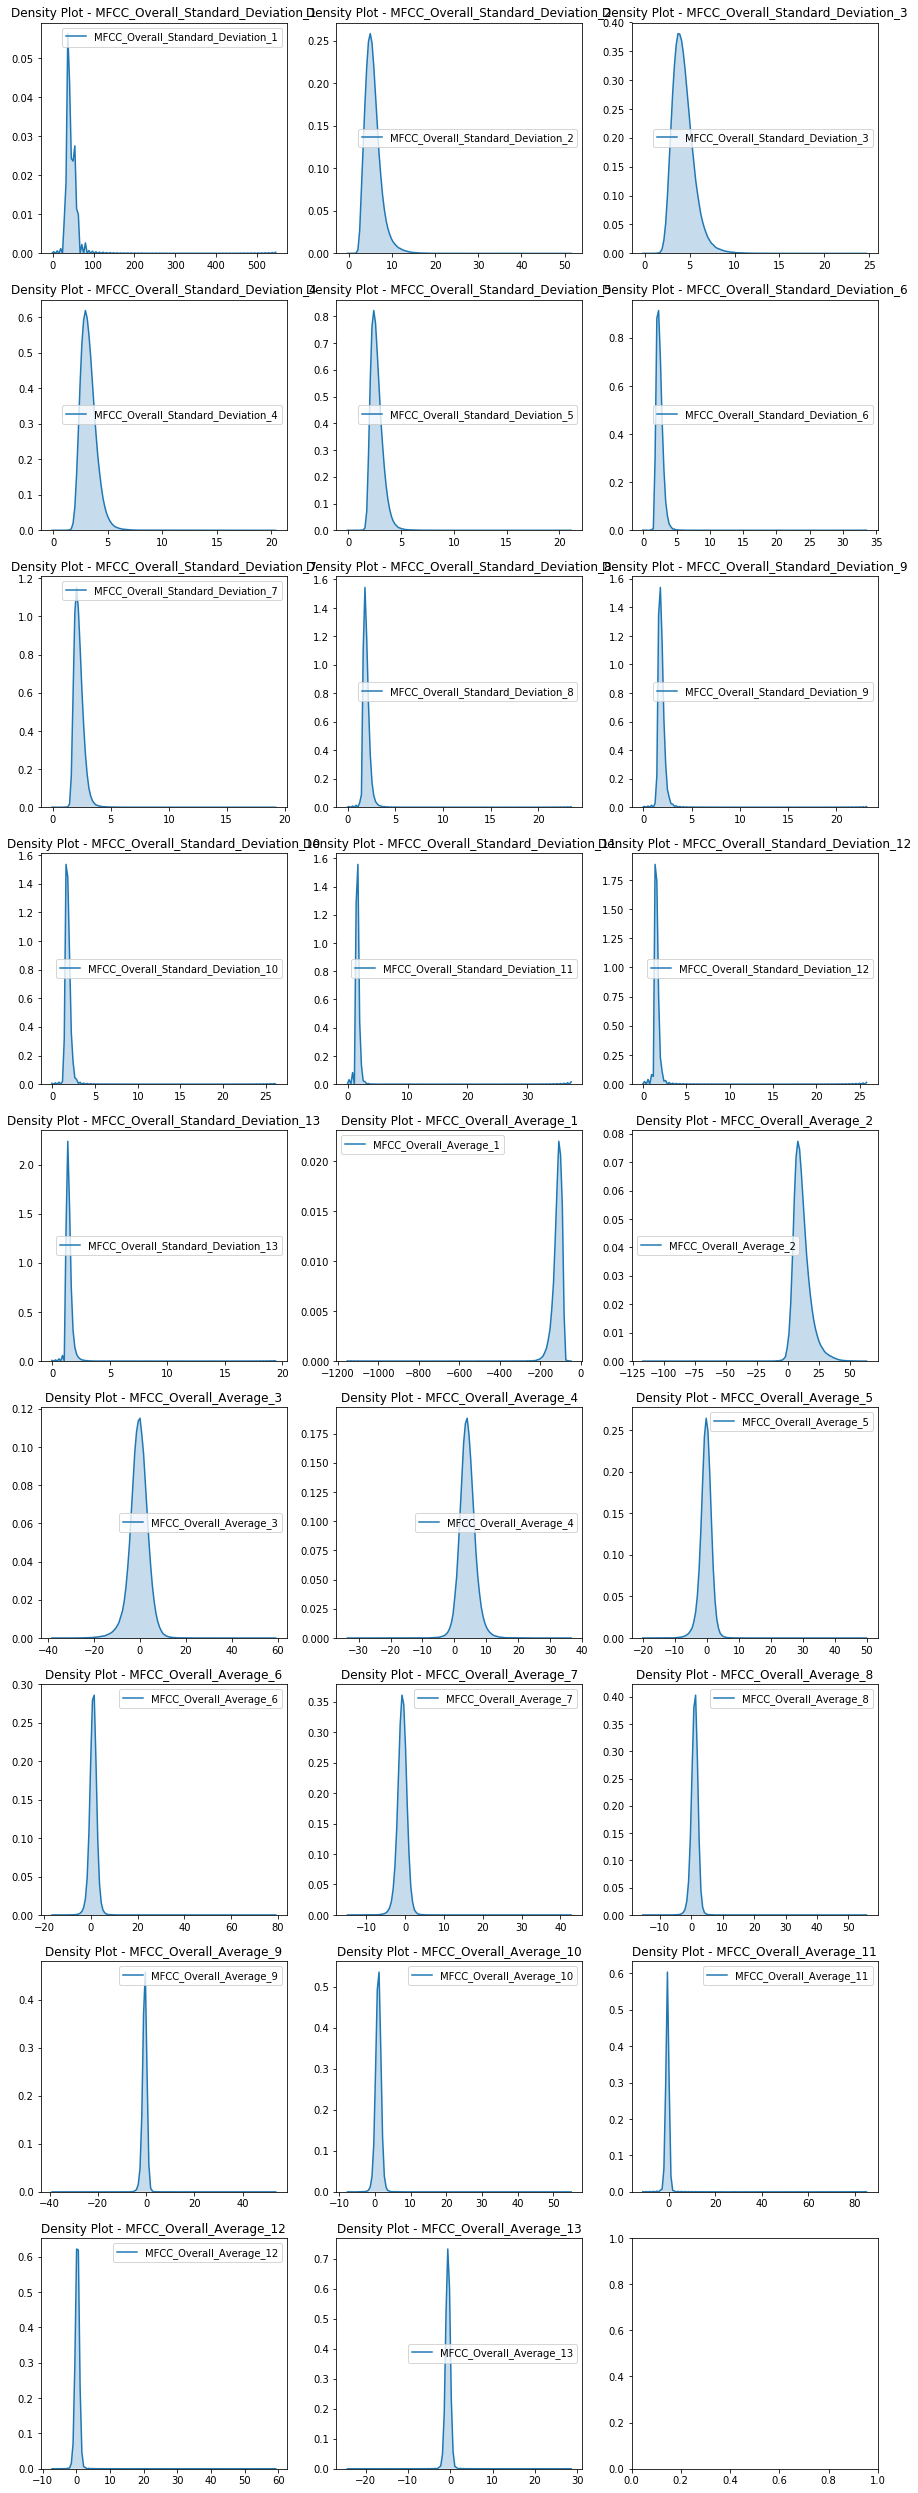

In [64]:
# Convert PySpark DataFrame to Pandas DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_pd = jmir_mfcc_all
data_pd = data_pd.toPandas()

# Determine the number of rows and columns for subplots
num_features = len(data_pd.columns)
num_cols = 3  # Number of columns for subplots
num_rows = -(-num_features // num_cols)  # Ceiling division to calculate number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes array if it's not already flat
axes = axes.flatten()

# Plot density plots for each feature in a subplot
for i, column in enumerate(data_pd.columns):
    sns.kdeplot(data_pd[column], ax=axes[i], shade=True)
    axes[i].set_title(f"Density Plot - {column}")

# Hide unused subplots
for j in range(i+1, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

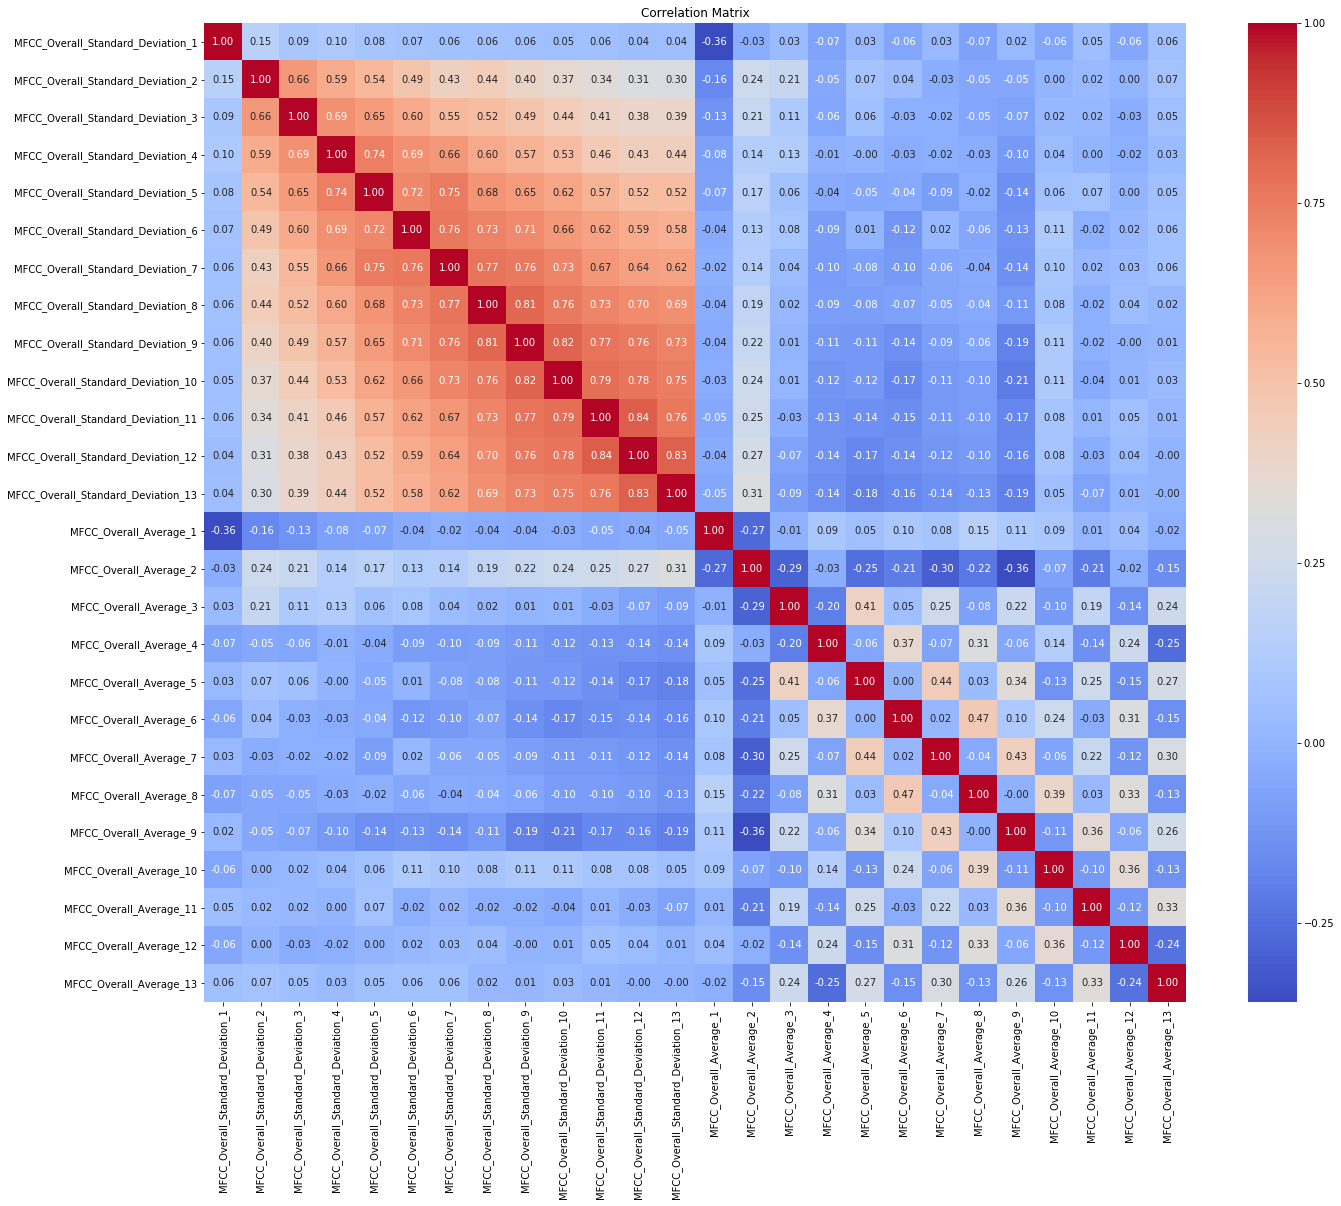

In [65]:
# Assuming jmir_mfcc_all is a PySpark DataFrame
from pyspark.sql.functions import col

columns = [
    'MFCC_Overall_Standard_Deviation_1', 'MFCC_Overall_Standard_Deviation_2', 'MFCC_Overall_Standard_Deviation_3',
    'MFCC_Overall_Standard_Deviation_4', 'MFCC_Overall_Standard_Deviation_5', 'MFCC_Overall_Standard_Deviation_6',
    'MFCC_Overall_Standard_Deviation_7', 'MFCC_Overall_Standard_Deviation_8', 'MFCC_Overall_Standard_Deviation_9',
    'MFCC_Overall_Standard_Deviation_10', 'MFCC_Overall_Standard_Deviation_11', 'MFCC_Overall_Standard_Deviation_12',
    'MFCC_Overall_Standard_Deviation_13', 'MFCC_Overall_Average_1', 'MFCC_Overall_Average_2', 'MFCC_Overall_Average_3',
    'MFCC_Overall_Average_4', 'MFCC_Overall_Average_5', 'MFCC_Overall_Average_6', 'MFCC_Overall_Average_7',
    'MFCC_Overall_Average_8', 'MFCC_Overall_Average_9', 'MFCC_Overall_Average_10', 'MFCC_Overall_Average_11',
    'MFCC_Overall_Average_12', 'MFCC_Overall_Average_13'
]

correlation_matrix = jmir_mfcc_all.select(columns).toPandas().corr()

# Plot the heatmap
plt.figure(figsize=(22, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


### (b)

In [66]:
genre.show(truncate=False)
genre.count()
#genre.printSchema()

+------------------+--------------+
|_c0               |_c1           |
+------------------+--------------+
|TRAAAAK128F9318786|Pop_Rock      |
|TRAAAAV128F421A322|Pop_Rock      |
|TRAAAAW128F429D538|Rap           |
|TRAAABD128F429CF47|Pop_Rock      |
|TRAAACV128F423E09E|Pop_Rock      |
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|Vocal         |
|TRAAAEF128F4273421|Pop_Rock      |
|TRAAAEM128F93347B9|Electronic    |
|TRAAAFD128F92F423A|Pop_Rock      |
|TRAAAFP128F931B4E3|Rap           |
|TRAAAGR128F425B14B|Pop_Rock      |
|TRAAAGW12903CC1049|Blues         |
|TRAAAHD128F42635A5|Pop_Rock      |
|TRAAAHE12903C9669C|Pop_Rock      |
|TRAAAHJ128F931194C|Pop_Rock      |
|TRAAAHZ128E0799171|Rap           |
|TRAAAIR128F1480971|RnB           |
|TRAAAJG128F9308A25|Folk          |
|TRAAAMO128F1481E7F|Religious     |
+------------------+--------------+
only showing top 20 rows



422714

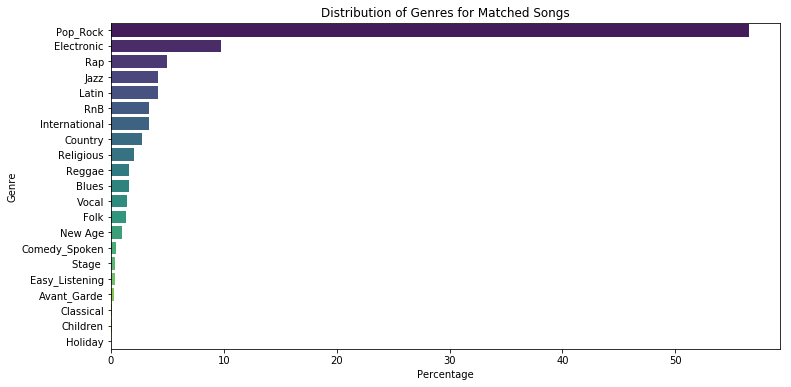

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

matched_df = genre

# Count the occurrences of each genre
genre_counts = matched_df.groupBy('_c1').count().orderBy('count', ascending=False).toPandas()

# Calculate the percentage
genre_counts['percentage'] = (genre_counts['count'] / genre_counts['count'].sum()) * 100

# Plot the distribution of genres with percentages
plt.figure(figsize=(12, 6))
sns.barplot(x='percentage', y='_c1', data=genre_counts, palette='viridis')
plt.xlabel('Percentage')
plt.ylabel('Genre')
plt.title('Distribution of Genres for Matched Songs')
plt.show()

### (c)

In [68]:
from pyspark.sql.functions import regexp_replace

# Assuming your DataFrame is called merged_df
jmir_mfcc_all = jmir_mfcc_all.withColumn('MSD_TRACKID', regexp_replace('MSD_TRACKID', "'", ''))
jmir_mfcc_all.show()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|MFCC_Overall_Standard_Dev

In [69]:
full_join_df = jmir_mfcc_all.join(genre, jmir_mfcc_all["MSD_TRACKID"] == genre["_c0"], how='left')

mfcc_genre1 = full_join_df.filter(col("_c0").isNotNull())

mfcc_genre = mfcc_genre1.drop('_c0')

#Show the resulting DataFrame
mfcc_genre.show()
#mfcc_genre.count()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|MFCC_Overal

In [72]:
#mfcc_genre.write.mode("overwrite").parquet("/user/hwa185/output/MDS/mfcc_genre.parquet")

In [109]:
mfcc_genre = spark.read.parquet("/user/hwa185/output/MDS/mfcc_genre.parquet")

In [111]:
mfcc_genre.count()

420620



## Q2
### (a) Logistic Regression, Random Forest and Gardient-Boosted Trees will be used.

### (b)

In [498]:
mfcc_genre.show()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|MFCC_Overal

In [321]:
from pyspark.sql.functions import when

# Assuming 'jmir_mfcc_all' is your PySpark DataFrame containing the 'genre' column
# Replace 'Electronic' with the actual genre value you want to check for

# Create a new column 'is_electronic' with binary values (1 for Electronic, 0 otherwise)
jmir_mfcc_binary = mfcc_genre.withColumn("is_electronic", when(mfcc_genre["Genre"] == "Electronic", 1).otherwise(0))

# Display the resulting DataFrame
jmir_mfcc_binary.show()
jmir_mfcc_binary.count()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+-------------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation

420620

In [331]:
from pyspark.sql.functions import col

counts = jmir_mfcc_binary.groupBy('is_electronic').count().orderBy('is_electronic')

# Display the counts
counts.show()

+-------------+------+
|is_electronic| count|
+-------------+------+
|            0|379954|
|            1| 40666|
+-------------+------+



In [351]:
# Filter the DataFrame to get rows where is_electronic is 0 or 1
electronic_0 = jmir_mfcc_binary.filter(jmir_mfcc_binary.is_electronic == 0)

# Show the extracted data
electronic_0.show()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+-------------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation

In [352]:
# Filter the DataFrame to get rows where is_electronic is 0 or 1
electronic_1 = jmir_mfcc_binary.filter(jmir_mfcc_binary.is_electronic == 1)

# Show the extracted data
electronic_1.show()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+----------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|

In [354]:
# Split the data into training and testing sets (80% training, 20% testing)
training_data0, testing_data0 = electronic_0.randomSplit([0.8, 0.2], seed=42)

# Show the sizes of the training and testing sets
print("Training data count0:", training_data0.count())
print("Testing data count0:", testing_data0.count())

Training data count0: 304288
Testing data count0: 75666


In [355]:
# Split the data into training and testing sets (80% training, 20% testing)
training_data1, testing_data1 = electronic_1.randomSplit([0.8, 0.2], seed=42)

# Show the sizes of the training and testing sets
print("Training data count1:", training_data1.count())
print("Testing data count1:", testing_data1.count())

Training data count1: 32672
Testing data count1: 7994


In [358]:
training_data = training_data1.union(training_data0)
testing_data = testing_data1.union(testing_data0)

print("Training data count:", training_data.count())
print("Testing data count:", testing_data.count())

Training data count: 336960
Testing data count: 83660


In [359]:
ori_counts_training = training_data.groupBy('is_electronic').count().orderBy('is_electronic')

# Display the counts
ori_counts_training.show()

+-------------+------+
|is_electronic| count|
+-------------+------+
|            0|304288|
|            1| 32672|
+-------------+------+



In [360]:
ori_counts_test = testing_data.groupBy('is_electronic').count().orderBy('is_electronic')

# Display the counts
ori_counts_test.show()

+-------------+-----+
|is_electronic|count|
+-------------+-----+
|            0|75666|
|            1| 7994|
+-------------+-----+



#### Stratified random

In [361]:
from pyspark.sql.functions import col, when
from pyspark.sql import Window
import random

df = jmir_mfcc_binary
from pyspark.sql.functions import col, rand

# Assuming df is your DataFrame
total_records = df.count()
electronic_records_needed = total_records // 4

# Oversample 'Electronic' genre
electronic_df = df.filter(col('genre') == 'Electronic')
electronic_count = electronic_df.count()
oversampling_ratio = electronic_records_needed / electronic_count
oversampled_electronic_df = electronic_df.sample(withReplacement=True, fraction=oversampling_ratio, seed=42)

# Sample the rest of the genres to maintain the original distribution
other_df = df.filter(col('genre') != 'Electronic')
sampled_other_df = other_df.sample(withReplacement=False, fraction=1.0, seed=42)

# Combine oversampled 'Electronic' genre with the rest of the dataset
resampled_df = oversampled_electronic_df.union(sampled_other_df)
resampled_df.show()
resampled_df.count()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+----------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|

484820

In [362]:
counts = resampled_df.groupBy('is_electronic').count().orderBy('is_electronic')

# Display the counts
counts.show()

+-------------+------+
|is_electronic| count|
+-------------+------+
|            0|379954|
|            1|104866|
+-------------+------+



In [273]:
## Assuming df is your DataFrame
#training_data, testing_data = resampled_df.randomSplit([0.7, 0.3], seed=100)
#
## Display the number of rows in each dataset
#print("Training data count:", training_data.count())
#print("Testing data count:", testing_data.count())

Training data count: 339230
Testing data count: 145590


In [185]:
training_data.show()
#training_data.printSchema()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+----------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|

In [186]:
train_counts = training_data.groupBy('is_electronic').count().orderBy('is_electronic')

# Display the counts
train_counts.show()
#339230

+-------------+------+
|is_electronic| count|
+-------------+------+
|            0|266114|
|            1| 73116|
+-------------+------+



In [119]:
testing_data.show()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+----------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|

In [187]:
test_counts = testing_data.groupBy('is_electronic').count().orderBy('is_electronic')

# Display the counts
test_counts.show()
#145590

+-------------+------+
|is_electronic| count|
+-------------+------+
|            0|113840|
|            1| 31750|
+-------------+------+



In [365]:
resampled_df

DataFrame[MFCC_Overall_Standard_Deviation_1: double, MFCC_Overall_Standard_Deviation_2: double, MFCC_Overall_Standard_Deviation_3: double, MFCC_Overall_Standard_Deviation_4: double, MFCC_Overall_Standard_Deviation_5: double, MFCC_Overall_Standard_Deviation_6: double, MFCC_Overall_Standard_Deviation_7: double, MFCC_Overall_Standard_Deviation_8: double, MFCC_Overall_Standard_Deviation_9: double, MFCC_Overall_Standard_Deviation_10: double, MFCC_Overall_Standard_Deviation_11: double, MFCC_Overall_Standard_Deviation_12: double, MFCC_Overall_Standard_Deviation_13: double, MFCC_Overall_Average_1: double, MFCC_Overall_Average_2: double, MFCC_Overall_Average_3: double, MFCC_Overall_Average_4: double, MFCC_Overall_Average_5: double, MFCC_Overall_Average_6: double, MFCC_Overall_Average_7: double, MFCC_Overall_Average_8: double, MFCC_Overall_Average_9: double, MFCC_Overall_Average_10: double, MFCC_Overall_Average_11: double, MFCC_Overall_Average_12: double, MFCC_Overall_Average_13: double, MSD_TRA

### (c)

#### Logistic Regression

In [282]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

In [397]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# List of feature columns
feature_cols = [
    "MFCC_Overall_Standard_Deviation_1", "MFCC_Overall_Standard_Deviation_2",
    "MFCC_Overall_Standard_Deviation_3", "MFCC_Overall_Standard_Deviation_4",
    "MFCC_Overall_Standard_Deviation_5", "MFCC_Overall_Standard_Deviation_6",
    "MFCC_Overall_Standard_Deviation_7", "MFCC_Overall_Standard_Deviation_8",
    "MFCC_Overall_Standard_Deviation_9", "MFCC_Overall_Standard_Deviation_10",
    "MFCC_Overall_Standard_Deviation_11", "MFCC_Overall_Standard_Deviation_12",
    "MFCC_Overall_Standard_Deviation_13", "MFCC_Overall_Average_1",
    "MFCC_Overall_Average_2", "MFCC_Overall_Average_3", "MFCC_Overall_Average_4",
    "MFCC_Overall_Average_5", "MFCC_Overall_Average_6", "MFCC_Overall_Average_7",
    "MFCC_Overall_Average_8", "MFCC_Overall_Average_9", "MFCC_Overall_Average_10",
    "MFCC_Overall_Average_11", "MFCC_Overall_Average_12", "MFCC_Overall_Average_13"
]

# Remove the existing "features" column in training data if it already exists
if "features" in training_data.columns:
    training_data = training_data.drop("features")
    
# Remove the existing "features" column in testing data if it already exists
if "features" in testing_data.columns:
    testing_data = testing_data.drop("features")

    # Remove the existing "features" column in training data if it already exists
if "standardized_features" in training_data.columns:
    training_data = training_data.drop("standardized_features")
    
# Remove the existing "features" column in testing data if it already exists
if "standardized_features" in testing_data.columns:
    testing_data = testing_data.drop("standardized_features")
# Apply the training data VectorAssembler transformation
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
training_data = assembler.transform(training_data)

# Apply the testing data VectorAssembler transformation
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
testing_data = assembler.transform(testing_data)

standard_scaler = StandardScaler(inputCol="features", outputCol="standardized_features", withStd=True, withMean=True)
standard_scaler_model = standard_scaler.fit(training_data)
standardized_df = standard_scaler_model.transform(training_data)
training_data = standardized_df

standard_scaler = StandardScaler(inputCol="features", outputCol="standardized_features", withStd=True, withMean=True)
standard_scaler_model = standard_scaler.fit(testing_data)
standardized_df = standard_scaler_model.transform(testing_data)
testing_data = standardized_df

# Train a logistic regression model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.0, featuresCol="features", labelCol="is_electronic")
model = lr.fit(training_data)

# Make predictions on test data
predictions = model.transform(testing_data)

## Evaluate precision, recall, accuracy, F1 score, and AUROC
#evaluator_multi = MulticlassClassificationEvaluator(labelCol="is_electronic", predictionCol="prediction")
#evaluator_bin = BinaryClassificationEvaluator(labelCol="is_electronic", rawPredictionCol="rawPrediction")
#
#precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
#recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
#accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
#f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
#auroc = evaluator_bin.evaluate(predictions, {evaluator_bin.metricName: "areaUnderROC"})
#
#print("Precision:", precision)
#print("Recall:", recall)
#print("Accuracy:", accuracy)
#print("F1 Score:", f1_score)
#print("AUROC:", auroc)

pred = predictions
pred.cache()
#show_as_html(predictions)
total = predictions.count()

nP_actual = pred.filter((F.col('is_electronic') == 1)).count()
nN_actual = pred.filter((F.col('is_electronic') == 0)).count()

nP = pred.filter((F.col('prediction') == 1)).count()
nN = pred.filter((F.col('prediction') == 0)).count()
TP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 1)).count()
FP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 0)).count()
FN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 1)).count()
TN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 0)).count()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / total
f1_score = 2 * (precision * recall) / (precision + recall)

binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_electronic', metricName='areaUnderROC')
auroc = binary_evaluator.evaluate(pred)

print(f'total:     {total}')
print(f'')
print(f'nP actual: {nP_actual}')
print(f'nP actual: {nN_actual}')
print(f'')
print(f'nP:        {nP}')
print(f'nN:        {nN}')
print(f'')
print(f'TP         {TP}')
print(f'FP         {FP}')
print(f'FN         {FN}')
print(f'TN         {TN}')
print(f'')
print(f'precision: {precision:.8f}')
print(f'recall:    {recall:.8f}')
print(f'accuracy:  {accuracy:.8f}')
print(f'F1_score:   {f1_score:.8f}')
print(f'')
print(f'auroc:     {auroc:.8f}')

total:     83660

nP actual: 7994
nP actual: 75666

nP:        5
nN:        83655

TP         4
FP         1
FN         7990
TN         75665

precision: 0.80000000
recall:    0.00050038
accuracy:  0.90448243
F1_score:   0.00100013

auroc:     0.76917161


#### Logistic Regression using stratified random data

In [395]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# List of feature columns
feature_cols = [
    "MFCC_Overall_Standard_Deviation_1", "MFCC_Overall_Standard_Deviation_2",
    "MFCC_Overall_Standard_Deviation_3", "MFCC_Overall_Standard_Deviation_4",
    "MFCC_Overall_Standard_Deviation_5", "MFCC_Overall_Standard_Deviation_6",
    "MFCC_Overall_Standard_Deviation_7", "MFCC_Overall_Standard_Deviation_8",
    "MFCC_Overall_Standard_Deviation_9", "MFCC_Overall_Standard_Deviation_10",
    "MFCC_Overall_Standard_Deviation_11", "MFCC_Overall_Standard_Deviation_12",
    "MFCC_Overall_Standard_Deviation_13", "MFCC_Overall_Average_1",
    "MFCC_Overall_Average_2", "MFCC_Overall_Average_3", "MFCC_Overall_Average_4",
    "MFCC_Overall_Average_5", "MFCC_Overall_Average_6", "MFCC_Overall_Average_7",
    "MFCC_Overall_Average_8", "MFCC_Overall_Average_9", "MFCC_Overall_Average_10",
    "MFCC_Overall_Average_11", "MFCC_Overall_Average_12", "MFCC_Overall_Average_13"
]

# Remove the existing "features" and "standardized_features" columns if they already exist
def remove_feature_cols(df):
    cols_to_remove = ["features", "standardized_features"]
    for col_name in cols_to_remove:
        if col_name in df.columns:
            df = df.drop(col_name)
    return df

training_data = remove_feature_cols(training_data)
testing_data = remove_feature_cols(testing_data)
resampled_df = remove_feature_cols(resampled_df)

# Apply the training data VectorAssembler transformation
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
resampled_df = assembler.transform(resampled_df)

# Apply the testing data VectorAssembler transformation
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
testing_data = assembler.transform(testing_data)

# Apply standard scaler
standard_scaler = StandardScaler(inputCol="features", outputCol="standardized_features", withStd=True, withMean=True)
standard_scaler_model = standard_scaler.fit(resampled_df)
standardized_train_data = standard_scaler_model.transform(resampled_df)
standardized_test_data = standard_scaler_model.transform(testing_data)

# Train a logistic regression model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.0, featuresCol="standardized_features", labelCol="is_electronic")
model = lr.fit(standardized_train_data)

# Make predictions on test data
predictions = model.transform(standardized_test_data)

## Evaluate precision, recall, accuracy, F1 score, and AUROC
#evaluator_multi = MulticlassClassificationEvaluator(labelCol="is_electronic", predictionCol="prediction")
#evaluator_bin = BinaryClassificationEvaluator(labelCol="is_electronic", rawPredictionCol="rawPrediction")
#
#precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
#recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
#accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
#f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
#auroc = evaluator_bin.evaluate(predictions, {evaluator_bin.metricName: "areaUnderROC"})
#
#print("Precision:", precision)
#print("Recall:", recall)
#print("Accuracy:", accuracy)
#print("F1 Score:", f1_score)
#print("AUROC:", auroc)

pred = predictions
pred.cache()
#show_as_html(predictions)
total = predictions.count()

nP_actual = pred.filter((F.col('is_electronic') == 1)).count()
nN_actual = pred.filter((F.col('is_electronic') == 0)).count()

nP = pred.filter((F.col('prediction') == 1)).count()
nN = pred.filter((F.col('prediction') == 0)).count()
TP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 1)).count()
FP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 0)).count()
FN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 1)).count()
TN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 0)).count()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / total
f1_score = 2 * (precision * recall) / (precision + recall)

binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_electronic', metricName='areaUnderROC')
auroc = binary_evaluator.evaluate(pred)

print(f'total:     {total}')
print(f'')
print(f'nP actual: {nP_actual}')
print(f'nP actual: {nN_actual}')
print(f'')
print(f'nP:        {nP}')
print(f'nN:        {nN}')
print(f'')
print(f'TP         {TP}')
print(f'FP         {FP}')
print(f'FN         {FN}')
print(f'TN         {TN}')
print(f'')
print(f'precision: {precision:.8f}')
print(f'recall:    {recall:.8f}')
print(f'accuracy:  {accuracy:.8f}')
print(f'F1_score:   {f1_score:.8f}')
print(f'')
print(f'auroc:     {auroc:.8f}')

total:     83660

nP actual: 7994
nP actual: 75666

nP:        875
nN:        82785

TP         587
FP         288
FN         7407
TN         75378

precision: 0.67085714
recall:    0.07343007
accuracy:  0.90802056
F1_score:   0.13237118

auroc:     0.77849460


#### Random Forest

In [398]:
from pyspark.ml.classification import RandomForestClassifier

# Create a Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="is_electronic", numTrees=300)
# Train the model
model = rf.fit(training_data)
# Make predictions on the test data
predictions = model.transform(testing_data)
# Evaluate the model
#evaluator = MulticlassClassificationEvaluator(labelCol="is_electronic", predictionCol="prediction")
#
## Calculate metrics
#precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
#recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
#accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
#f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
#
#print("Precision:", precision)
#print("Recall:", recall)
#print("Accuracy:", accuracy)
#print("F1 Score:", f1_score)

pred = predictions
pred.cache()
#show_as_html(predictions)
total = predictions.count()

nP_actual = pred.filter((F.col('is_electronic') == 1)).count()
nN_actual = pred.filter((F.col('is_electronic') == 0)).count()

nP = pred.filter((F.col('prediction') == 1)).count()
nN = pred.filter((F.col('prediction') == 0)).count()
TP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 1)).count()
FP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 0)).count()
FN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 1)).count()
TN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 0)).count()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / total
f1_score = 2 * (precision * recall) / (precision + recall)

binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_electronic', metricName='areaUnderROC')
auroc = binary_evaluator.evaluate(pred)

print(f'total:     {total}')
print(f'')
print(f'nP actual: {nP_actual}')
print(f'nP actual: {nN_actual}')
print(f'')
print(f'nP:        {nP}')
print(f'nN:        {nN}')
print(f'')
print(f'TP         {TP}')
print(f'FP         {FP}')
print(f'FN         {FN}')
print(f'TN         {TN}')
print(f'')
print(f'precision: {precision:.8f}')
print(f'recall:    {recall:.8f}')
print(f'accuracy:  {accuracy:.8f}')
print(f'F1_score:   {f1_score:.8f}')
print(f'')
print(f'auroc:     {auroc:.8f}')

total:     83660

nP actual: 7994
nP actual: 75666

nP:        182
nN:        83478

TP         137
FP         45
FN         7857
TN         75621

precision: 0.75274725
recall:    0.01713785
accuracy:  0.90554626
F1_score:   0.03351272

auroc:     0.77542624


#### Random Forest using stratified random data

In [399]:
# Create a Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="is_electronic", numTrees=300)
# Train the model
model = rf.fit(resampled_df)
# Make predictions on the test data
predictions = model.transform(testing_data)
## Evaluate the model
#evaluator = MulticlassClassificationEvaluator(labelCol="is_electronic", predictionCol="prediction")
#
## Calculate metrics
#precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
#recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
#accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
#f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
#
#print("Precision:", precision)
#print("Recall:", recall)
#print("Accuracy:", accuracy)
#print("F1 Score:", f1_score)

pred = predictions
pred.cache()
#show_as_html(predictions)
total = predictions.count()

nP_actual = pred.filter((F.col('is_electronic') == 1)).count()
nN_actual = pred.filter((F.col('is_electronic') == 0)).count()

nP = pred.filter((F.col('prediction') == 1)).count()
nN = pred.filter((F.col('prediction') == 0)).count()
TP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 1)).count()
FP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 0)).count()
FN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 1)).count()
TN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 0)).count()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / total
f1_score = 2 * (precision * recall) / (precision + recall)

binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_electronic', metricName='areaUnderROC')
auroc = binary_evaluator.evaluate(pred)

print(f'total:     {total}')
print(f'')
print(f'nP actual: {nP_actual}')
print(f'nP actual: {nN_actual}')
print(f'')
print(f'nP:        {nP}')
print(f'nN:        {nN}')
print(f'')
print(f'TP         {TP}')
print(f'FP         {FP}')
print(f'FN         {FN}')
print(f'TN         {TN}')
print(f'')
print(f'precision: {precision:.8f}')
print(f'recall:    {recall:.8f}')
print(f'accuracy:  {accuracy:.8f}')
print(f'F1_score:   {f1_score:.8f}')
print(f'')
print(f'auroc:     {auroc:.8f}')

total:     83660

nP actual: 7994
nP actual: 75666

nP:        2014
nN:        81646

TP         1237
FP         777
FN         6757
TN         74889

precision: 0.61420060
recall:    0.15474106
accuracy:  0.90994502
F1_score:   0.24720224

auroc:     0.79242905


#### Gardient-Boosted Trees

In [400]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a GBT model
gbt = GBTClassifier(labelCol="is_electronic", featuresCol="features", maxIter=200)
model = gbt.fit(training_data)

# Make predictions
predictions = model.transform(testing_data)

#evaluator = MulticlassClassificationEvaluator(labelCol="is_electronic", predictionCol="prediction")
#
## Calculate metrics
#precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
#recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
#accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
#f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
#
#print("Precision:", precision)
#print("Recall:", recall)
#print("Accuracy:", accuracy)
#print("F1 Score:", f1_score)

pred = predictions
pred.cache()
#show_as_html(predictions)
total = predictions.count()

nP_actual = pred.filter((F.col('is_electronic') == 1)).count()
nN_actual = pred.filter((F.col('is_electronic') == 0)).count()

nP = pred.filter((F.col('prediction') == 1)).count()
nN = pred.filter((F.col('prediction') == 0)).count()
TP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 1)).count()
FP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 0)).count()
FN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 1)).count()
TN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 0)).count()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / total
f1_score = 2 * (precision * recall) / (precision + recall)

binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_electronic', metricName='areaUnderROC')
auroc = binary_evaluator.evaluate(pred)

print(f'total:     {total}')
print(f'')
print(f'nP actual: {nP_actual}')
print(f'nP actual: {nN_actual}')
print(f'')
print(f'nP:        {nP}')
print(f'nN:        {nN}')
print(f'')
print(f'TP         {TP}')
print(f'FP         {FP}')
print(f'FN         {FN}')
print(f'TN         {TN}')
print(f'')
print(f'precision: {precision:.8f}')
print(f'recall:    {recall:.8f}')
print(f'accuracy:  {accuracy:.8f}')
print(f'F1_score:   {f1_score:.8f}')
print(f'')
print(f'auroc:     {auroc:.8f}')

total:     83660

nP actual: 7994
nP actual: 75666

nP:        3224
nN:        80436

TP         2078
FP         1146
FN         5916
TN         74520

precision: 0.64454094
recall:    0.25994496
accuracy:  0.91558690
F1_score:   0.37047602

auroc:     0.85679428


#### Gardient-Boosted Trees using stratified random data

In [401]:
# Train a GBT model
gbt = GBTClassifier(labelCol="is_electronic", featuresCol="features", maxIter=200)
model = gbt.fit(resampled_df)

# Make predictions
predictions = model.transform(testing_data)

#evaluator = MulticlassClassificationEvaluator(labelCol="is_electronic", predictionCol="prediction")
#
## Calculate metrics
#precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
#recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
#accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
#f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
#
#print("Precision:", precision)
#print("Recall:", recall)
#print("Accuracy:", accuracy)
#print("F1 Score:", f1_score)

pred = predictions
pred.cache()
#show_as_html(predictions)
total = predictions.count()

nP_actual = pred.filter((F.col('is_electronic') == 1)).count()
nN_actual = pred.filter((F.col('is_electronic') == 0)).count()

nP = pred.filter((F.col('prediction') == 1)).count()
nN = pred.filter((F.col('prediction') == 0)).count()
TP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 1)).count()
FP = pred.filter((F.col('prediction') == 1) & (F.col('is_electronic') == 0)).count()
FN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 1)).count()
TN = pred.filter((F.col('prediction') == 0) & (F.col('is_electronic') == 0)).count()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / total
f1_score = 2 * (precision * recall) / (precision + recall)

binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_electronic', metricName='areaUnderROC')
auroc = binary_evaluator.evaluate(pred)

print(f'total:     {total}')
print(f'')
print(f'nP actual: {nP_actual}')
print(f'nP actual: {nN_actual}')
print(f'')
print(f'nP:        {nP}')
print(f'nN:        {nN}')
print(f'')
print(f'TP         {TP}')
print(f'FP         {FP}')
print(f'FN         {FN}')
print(f'TN         {TN}')
print(f'')
print(f'precision: {precision:.8f}')
print(f'recall:    {recall:.8f}')
print(f'accuracy:  {accuracy:.8f}')
print(f'F1_score:   {f1_score:.8f}')
print(f'')
print(f'auroc:     {auroc:.8f}')

total:     83660

nP actual: 7994
nP actual: 75666

nP:        7225
nN:        76435

TP         3973
FP         3252
FN         4021
TN         72414

precision: 0.54989619
recall:    0.49699775
accuracy:  0.91306479
F1_score:   0.52211052

auroc:     0.87660558


## Q4

###### Random Forest will be used in this senario.

#### (b)

In [416]:
mfcc_genre.show()
mfcc_genre.count()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+-------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|MFCC_Overal

420620

In [419]:
# Assuming 'Genre' is the column you want to group by
genre_counts = mfcc_genre.groupBy('Genre').count()

# Show the counts for each genre
genre_counts.show(50)


+--------------+------+
|         Genre| count|
+--------------+------+
|     Religious|  8780|
|         Vocal|  6182|
|         Blues|  6801|
|      Children|   463|
|       New Age|  4000|
|     Classical|   555|
|        Reggae|  6931|
|       Holiday|   200|
|        Stage |  1613|
|Easy_Listening|  1535|
|    Electronic| 40666|
|          Jazz| 17775|
| International| 14194|
|           RnB| 14314|
|           Rap| 20899|
|   Avant_Garde|  1012|
|         Latin| 17504|
|          Folk|  5789|
|      Pop_Rock|237649|
|       Country| 11691|
| Comedy_Spoken|  2067|
+--------------+------+



In [421]:
from pyspark.sql import functions as F

# Calculate the total count
total_count = genre_counts.agg(F.sum("count")).collect()[0][0]

# Calculate the ratio
ratio_df = genre_counts.withColumn("Ratio", F.col("count") / total_count)

# Show the result
ratio_df.show()


+--------------+------+--------------------+
|         Genre| count|               Ratio|
+--------------+------+--------------------+
|     Religious|  8780|0.020873947981551042|
|         Vocal|  6182|0.014697351528695736|
|      Children|   463|0.001100756026817555|
|         Blues|  6801| 0.01616898863582331|
|       New Age|  4000|0.009509771290000475|
|     Classical|   555|0.001319480766487566|
|        Reggae|  6931|0.016478056202748323|
|       Holiday|   200|4.754885645000237...|
|        Stage |  1613|0.003834815272692692|
|Easy_Listening|  1535|0.003649374732537...|
|          Jazz| 17775| 0.04225904616993961|
|    Electronic| 40666| 0.09668108981978983|
| International| 14194| 0.03374542342256669|
|           RnB| 14314|  0.0340307165612667|
|           Rap| 20899| 0.04968617754742998|
|   Avant_Garde|  1012| 0.00240597213637012|
|         Latin| 17504| 0.04161475916504208|
|          Folk|  5789|0.013763016499453188|
|      Pop_Rock|237649|  0.5649969093243308|
|       Co

In [417]:
from pyspark.ml.feature import StringIndexer

# Create the StringIndexer
indexer = StringIndexer(inputCol="Genre", outputCol="GenreIndex")

# Fit and transform the DataFrame
indexed_df = indexer.fit(mfcc_genre).transform(mfcc_genre)

mfcc_genre_integer = indexed_df.withColumn("GenreIndex", col("GenreIndex").cast(IntegerType()))

mfcc_genre_integer.show()
mfcc_genre_integer.count()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+-------------+----------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|

420620

In [422]:
# Assuming 'Genre' is the column you want to group by
genre_counts = mfcc_genre_integer.groupBy('GenreIndex').count()

# Show the counts for each genre
genre_counts.show(50)

+----------+------+
|GenreIndex| count|
+----------+------+
|        12|  5789|
|        18|   555|
|        10|  6801|
|         1| 40666|
|         3| 17775|
|        20|   200|
|        13|  4000|
|        14|  2067|
|         9|  6931|
|         6| 14194|
|         7| 11691|
|        11|  6182|
|         0|237649|
|         8|  8780|
|        16|  1535|
|         5| 14314|
|         2| 20899|
|        17|  1012|
|        15|  1613|
|        19|   463|
|         4| 17504|
+----------+------+



In [426]:
from pyspark.sql import functions as F

# Calculate the total count
total_count = genre_counts.agg(F.sum("count")).collect()[0][0]

# Calculate the ratio
ratio_df = genre_counts.withColumn("Ratio", F.col("count") / total_count)

# Show the result
#ratio_df.show()
# Sort genres by ratio in descending order
sorted_ratio_df = ratio_df.orderBy(F.desc("Ratio"))

# Show the result
sorted_ratio_df.show(30)


+----------+------+--------------------+
|GenreIndex| count|               Ratio|
+----------+------+--------------------+
|         0|237649|  0.5649969093243308|
|         1| 40666| 0.09668108981978983|
|         2| 20899| 0.04968617754742998|
|         3| 17775| 0.04225904616993961|
|         4| 17504| 0.04161475916504208|
|         5| 14314|  0.0340307165612667|
|         6| 14194| 0.03374542342256669|
|         7| 11691| 0.02779468403784889|
|         8|  8780|0.020873947981551042|
|         9|  6931|0.016478056202748323|
|        10|  6801| 0.01616898863582331|
|        11|  6182|0.014697351528695736|
|        12|  5789|0.013763016499453188|
|        13|  4000|0.009509771290000475|
|        14|  2067|0.004914174314107745|
|        15|  1613|0.003834815272692692|
|        16|  1535|0.003649374732537...|
|        17|  1012| 0.00240597213637012|
|        18|   555|0.001319480766487566|
|        19|   463|0.001100756026817555|
|        20|   200|4.754885645000237...|
+----------+----

In [454]:
# Assuming your original DataFrame is named 'data'
training_data_mul, testing_data_mul = mfcc_genre_integer.randomSplit([0.8, 0.2], seed=42)
training_data_mul.show()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+-------------+----------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Standard_Deviation_6|

In [433]:
# Assuming 'Genre' is the column you want to group by
genre_counts = training_data_mul.groupBy('GenreIndex').count()

# Show the counts for each genre
#genre_counts.show(50)# Calculate the total count
total_count = genre_counts.agg(F.sum("count")).collect()[0][0]


# Calculate the ratio
ratio_df = genre_counts.withColumn("Ratio", F.col("count") / total_count)

# Show the result
#ratio_df.show()
# Sort genres by ratio in descending order
sorted_ratio_df = ratio_df.orderBy(F.desc("Ratio"))

# Show the result
sorted_ratio_df.show(30)

+----------+------+--------------------+
|GenreIndex| count|               Ratio|
+----------+------+--------------------+
|         0|190339|  0.5651143802977896|
|         1| 32519| 0.09654855039116429|
|         2| 16732|0.049677122455947624|
|         3| 14349| 0.04260202188144827|
|         4| 14027| 0.04164600745216217|
|         6| 11404| 0.03385834953906447|
|         5| 11318|  0.0336030164927334|
|         7|  9416|0.027955999584341553|
|         8|  7021| 0.02084527114291228|
|         9|  5539| 0.01644522957706753|
|        10|  5416| 0.01608004394103588|
|        11|  4977|0.014776657809183082|
|        12|  4633|0.013755325623858795|
|        13|  3207|0.009521547437020323|
|        14|  1609|0.004777103157519707|
|        15|  1281|0.003803274794768...|
|        16|  1236|0.003669670293781...|
|        17|   819|0.002431601917966...|
|        18|   441|0.001309324109674...|
|        19|   378|0.001122277808292386|
|        20|   154|4.572242922672684E-4|
+----------+----

In [434]:
# Assuming 'Genre' is the column you want to group by
genre_counts = testing_data_mul.groupBy('GenreIndex').count()

# Show the counts for each genre
#genre_counts.show(50)# Calculate the total count
total_count = genre_counts.agg(F.sum("count")).collect()[0][0]


# Calculate the ratio
ratio_df = genre_counts.withColumn("Ratio", F.col("count") / total_count)

# Show the result
#ratio_df.show()
# Sort genres by ratio in descending order
sorted_ratio_df = ratio_df.orderBy(F.desc("Ratio"))

# Show the result
sorted_ratio_df.show(30)

+----------+-----+--------------------+
|GenreIndex|count|               Ratio|
+----------+-----+--------------------+
|         0|47310|  0.5645247896903526|
|         1| 8147| 0.09721377006145218|
|         2| 4167|0.049722570252371576|
|         4| 3477| 0.04148917129049579|
|         3| 3426|0.040880615715052804|
|         5| 2996| 0.03574965694170992|
|         6| 2790| 0.03329156971541077|
|         7| 2275| 0.02714635164966291|
|         8| 1759|0.020989201121651452|
|         9| 1392|0.016609987470914623|
|        10| 1385|0.016526460235069505|
|        11| 1205| 0.01437861702762365|
|        12| 1156|0.013793926376707833|
|        13|  793|0.009462442575025357|
|        14|  458|0.005465067716723346|
|        15|  332|0.003961577471511247|
|        16|  299|0.003567806216812839|
|        17|  193|0.002302965216872...|
|        18|  114|0.001360300698049...|
|        19|   85|0.001014259292404...|
|        20|   46|5.488932641250522E-4|
+----------+-----+--------------------+


###### Resample training data

In [471]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from functools import reduce

# Assuming 'training_data' is your DataFrame
major_df = training_data_mul.filter(col('GenreIndex') == 0)
minor_df = training_data_mul.filter(col('GenreIndex') != 0)

# Calculate the ratio between the majority class and each minority class
ratios = {index: int(major_df.count() / minor_df.filter(col('GenreIndex') == index).count()) 
          for index in minor_df.select('GenreIndex').distinct().rdd.map(lambda x: x[0]).collect()}

# Replicate samples from each minority class to match the size of the majority class
balanced_dfs = []
for index, ratio in ratios.items():
    minor_df_class = minor_df.filter(col('GenreIndex') == index)
    balanced_df_class = minor_df_class.withColumn("dummy", F.expr("explode(array_repeat(struct(*), {}))".format(ratio))) \
        .drop('dummy')
    balanced_dfs.append(balanced_df_class)

balanced_df = reduce(lambda df1, df2: df1.union(df2), balanced_dfs, major_df)

balanced_df.show()

+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+--------+----------+--------------------+
|MFCC_Overall_Standard_Deviation_1|MFCC_Overall_Standard_Deviation_2|MFCC_Overall_Standard_Deviation_3|MFCC_Overall_Standard_Deviation_4|MFCC_Overall_Standard_Deviation_5|MFCC_Overall_Stand

In [453]:
# Assuming 'Genre' is the column you want to group by
genre_counts = balanced_df.groupBy('GenreIndex').count()

# Show the counts for each genre
#genre_counts.show(50)# Calculate the total count
total_count = genre_counts.agg(F.sum("count")).collect()[0][0]


# Calculate the ratio
ratio_df = genre_counts.withColumn("Ratio", F.col("count") / total_count)

# Show the result
#ratio_df.show()
# Sort genres by ratio in descending order
sorted_ratio_df = ratio_df.orderBy(F.desc("Ratio"))

# Show the result
sorted_ratio_df.show(30)

+----------+------+--------------------+
|GenreIndex| count|               Ratio|
+----------+------+--------------------+
|         0|190339| 0.04852551414268422|
|        20|190190| 0.04848752769951041|
|        19|190134|0.048473250915498776|
|        18|190071|0.048457189533485684|
|        17|190008|  0.0484411281514726|
|        12|189953|  0.0484271063100326|
|        14|189862|0.048403906536013695|
|        15|189588| 0.04833405227138535|
|         8|189567|0.048328698477380985|
|        10|189560|0.048326913879379534|
|        13|189213| 0.04823844880702173|
|        11|189126| 0.04821626880328937|
|        16|189108|0.048211679836999914|
|         9|188326| 0.04801231474598032|
|         7|188320|0.048010785090550505|
|         3|186537| 0.04755622248532296|
|         2|184052|0.046922690194806715|
|         6|182464|0.046517841391048254|
|         4|182351| 0.04648903288045335|
|         5|181088|0.046167040412476684|
|         1|162595| 0.04145238743520634|
+----------+----

In [470]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from itertools import chain

#feature_cols = [
#    "MFCC_Overall_Standard_Deviation_1", "MFCC_Overall_Standard_Deviation_2",
#    "MFCC_Overall_Standard_Deviation_3", "MFCC_Overall_Standard_Deviation_4",
#    "MFCC_Overall_Standard_Deviation_5", "MFCC_Overall_Standard_Deviation_6",
#    "MFCC_Overall_Standard_Deviation_7", "MFCC_Overall_Standard_Deviation_8",
#    "MFCC_Overall_Standard_Deviation_9", "MFCC_Overall_Standard_Deviation_10",
#    "MFCC_Overall_Standard_Deviation_11", "MFCC_Overall_Standard_Deviation_12",
#    "MFCC_Overall_Standard_Deviation_13", "MFCC_Overall_Average_1",
#    "MFCC_Overall_Average_2", "MFCC_Overall_Average_3", "MFCC_Overall_Average_4",
#    "MFCC_Overall_Average_5", "MFCC_Overall_Average_6", "MFCC_Overall_Average_7",
#    "MFCC_Overall_Average_8", "MFCC_Overall_Average_9", "MFCC_Overall_Average_10",
#    "MFCC_Overall_Average_11", "MFCC_Overall_Average_12", "MFCC_Overall_Average_13"
#]
#
## Assemble the feature columns into a single vector column
#assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
##training_data_mul = assembler.transform(training_data_mul)
##testing_data_mul = assembler.transform(testing_data_mul)
#balanced_df = assembler.transform(balanced_df)

In [475]:
# Create a Random Forest classifier instance
rf = RandomForestClassifier(featuresCol="features_vector", labelCol="GenreIndex", numTrees=400)

# Fit the model to the training data
model = rf.fit(training_data_mul)

# Make predictions on the test data
predictions = model.transform(testing_data_mul)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="GenreIndex", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
#print("Accuracy:", accuracy)

# Optional: You can also print other metrics such as precision, recall, F1-score, etc.
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Compute metrics for each class
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="GenreIndex")
metrics = {}

# Compute precision, recall, and F1-score for each label
num_classes = 21
for label in range(0, num_classes):  # Assuming num_classes is the total number of classes
    # Filter predictions for the current label
    filtered_predictions = predictions.filter(predictions["GenreIndex"] == label)
    
    # Calculate metrics
    precision = evaluator.evaluate(filtered_predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(filtered_predictions, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(filtered_predictions, {evaluator.metricName: "f1"})
    
    metrics[label] = {"precision": precision, "recall": recall, "f1_score": f1_score}

# Print metrics for each label
for label, values in metrics.items():
    print(f"Metrics for Label {label}:")
    print(f"Precision: {values['precision']}")
    print(f"Recall: {values['recall']}")
    print(f"F1 Score: {values['f1_score']}")
    print()

Metrics for Label 0:
Precision: 1.0
Recall: 0.9963644049883745
F1 Score: 0.9981788920887683

Metrics for Label 1:
Precision: 1.0
Recall: 0.0254081256904382
F1 Score: 0.04955709839597798

Metrics for Label 2:
Precision: 1.0
Recall: 0.13246940244780417
F1 Score: 0.23394787031150668

Metrics for Label 3:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 4:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 5:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 6:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 7:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 8:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 9:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 10:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 11:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 12:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 13:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 14:

###### Using Resampled data for training model

In [477]:
# Create a Random Forest classifier instance
rf = RandomForestClassifier(featuresCol="features_vector", labelCol="GenreIndex", numTrees=400)

# Fit the model to the training data
model = rf.fit(balanced_df)

# Make predictions on the test data
predictions = model.transform(testing_data_mul)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="GenreIndex", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
#print("Accuracy:", accuracy)

# Optional: You can also print other metrics such as precision, recall, F1-score, etc.
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Compute metrics for each class
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="GenreIndex")
metrics = {}

# Compute precision, recall, and F1-score for each label
num_classes = 21
for label in range(0, num_classes):  # Assuming num_classes is the total number of classes
    # Filter predictions for the current label
    filtered_predictions = predictions.filter(predictions["GenreIndex"] == label)
    
    # Calculate metrics
    precision = evaluator.evaluate(filtered_predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(filtered_predictions, {evaluator.metricName: "weightedRecall"})
    f1_score = evaluator.evaluate(filtered_predictions, {evaluator.metricName: "f1"})
    
    metrics[label] = {"precision": precision, "recall": recall, "f1_score": f1_score}

# Print metrics for each label
for label, values in metrics.items():
    print(f"Metrics for Label {label}:")
    print(f"Precision: {values['precision']}")
    print(f"Recall: {values['recall']}")
    print(f"F1 Score: {values['f1_score']}")
    print()

Metrics for Label 0:
Precision: 1.0
Recall: 0.4848657789050941
F1 Score: 0.653076912126863

Metrics for Label 1:
Precision: 1.0
Recall: 0.052902909046274704
F1 Score: 0.1004896246211238

Metrics for Label 2:
Precision: 1.0
Recall: 0.5281977441804656
F1 Score: 0.6912688442211056

Metrics for Label 3:
Precision: 1.0
Recall: 0.19935785172212492
F1 Score: 0.3324409832075931

Metrics for Label 4:
Precision: 1.0
Recall: 0.0638481449525453
F1 Score: 0.12003244120032443

Metrics for Label 5:
Precision: 1.0
Recall: 0.21061415220293725
F1 Score: 0.34794596084918666

Metrics for Label 6:
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for Label 7:
Precision: 1.0
Recall: 0.15692307692307692
F1 Score: 0.2712765957446808

Metrics for Label 8:
Precision: 1.0
Recall: 0.18646958499147243
F1 Score: 0.3143267848586488

Metrics for Label 9:
Precision: 1.0
Recall: 0.33764367816091956
F1 Score: 0.5048335123523093

Metrics for Label 10:
Precision: 1.0
Recall: 0.06570397111913358
F1 Score: 0.123306233062330

# Song recommendations

## Q1

In [4]:
file_path = [
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00000.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00001.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00002.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00003.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00004.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00005.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00006.tsv.gz",
    "hdfs:///data/msd/tasteprofile/triplets.tsv/part-00007.tsv.gz"]

triplets = spark.read.csv(file_path, sep='\t', header=False)
triplets.show(truncate = False)
triplets.count()

+----------------------------------------+------------------+---+
|_c0                                     |_c1               |_c2|
+----------------------------------------+------------------+---+
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQEFDN12AB017C52B|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOIUJ12A6701DAA7|2  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOKKD12A6701F92E|4  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSDVHO12AB01882C7|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSKICX12A6701F932|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSNUPV12A8C13939B|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSVMII12A6701F92D|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTUNHI12B0B80AFE2|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTXLTZ12AB017C535|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTZDDX12A6701F935|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTZTVF12A58A79B9F|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOUGTZZ12A8C13B8CC|1  |
|f1bfc2a45

48373586

In [82]:
#triplets.write.mode("overwrite").parquet("/user/hwa185/output/MDS/triplets.parquet")
triplets = spark.read.parquet("/user/hwa185/output/MDS/triplets.parquet")
triplets.show()

+--------------------+------------------+---+
|                 _c0|               _c1|_c2|
+--------------------+------------------+---+
|f1bfc2a4597a3642f...|SOQEFDN12AB017C52B|  1|
|f1bfc2a4597a3642f...|SOQOIUJ12A6701DAA7|  2|
|f1bfc2a4597a3642f...|SOQOKKD12A6701F92E|  4|
|f1bfc2a4597a3642f...|SOSDVHO12AB01882C7|  1|
|f1bfc2a4597a3642f...|SOSKICX12A6701F932|  1|
|f1bfc2a4597a3642f...|SOSNUPV12A8C13939B|  1|
|f1bfc2a4597a3642f...|SOSVMII12A6701F92D|  1|
|f1bfc2a4597a3642f...|SOTUNHI12B0B80AFE2|  1|
|f1bfc2a4597a3642f...|SOTXLTZ12AB017C535|  1|
|f1bfc2a4597a3642f...|SOTZDDX12A6701F935|  1|
|f1bfc2a4597a3642f...|SOTZTVF12A58A79B9F|  1|
|f1bfc2a4597a3642f...|SOUGTZZ12A8C13B8CC|  1|
|f1bfc2a4597a3642f...|SOVDLVW12A6701F92F|  1|
|f1bfc2a4597a3642f...|SOVKHBC12AF72A5DE7|  1|
|f1bfc2a4597a3642f...|SOVKJMM12AF72AAF3C|  1|
|f1bfc2a4597a3642f...|SOVMWUC12A8C13750B|  1|
|f1bfc2a4597a3642f...|SOVQPUM12A6D4F8F18|  1|
|f1bfc2a4597a3642f...|SOVVTJV12AB017B20E|  1|
|f1bfc2a4597a3642f...|SOXREWC12A6D

In [6]:
# Number of unique songs
unique_songs = triplets.select("_c1").distinct().count()

# Number of unique users
unique_users = triplets.select("_c0").distinct().count()

print(f"Number of unique songs: {unique_songs}")
print(f"Number of unique users: {unique_users}")

Number of unique songs: 384546
Number of unique users: 1019318


In [83]:
sid_mismaches = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("inferSchema", "false")
    .option("delimiter", "\t")
    .load("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")
)

sid_mismaches.show(truncate = False)
sid_mismaches.count()

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_c0                                                                                                                                                                       |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground                                   |
|ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1> Jimmy Reed  -  The Sun Is Shining (Digitally Remastered)  !=  Slim Harpo  -  I Got Love If You Want It                     |
|ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E> Africa HiTech  -  Footstep  !=  Marcus Worgull  -  Drumstern (BONUS TRACK)             

19094

In [84]:
from pyspark.sql.functions import regexp_extract

# Assuming your DataFrame is named df and the column containing the data is named _c0
extracted_df = sid_mismaches.withColumn("extracted_id", regexp_extract(sid_mismaches["_c0"], r'<([^ ]+)', 1))

# Show the DataFrame with the extracted IDs
extracted_df.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|_c0                                                                                                                                                                       |extracted_id      |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground                                   |SOUMNSI12AB0182807|
|ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1> Jimmy Reed  -  The Sun Is Shining (Digitally Remastered)  !=  Slim Harpo  -  I Got Love If You Want It                     |SOCMRBE12AB018C546|
|ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903

In [85]:
# Assuming your DataFrame is named df and the column containing the extracted ID is named extracted_id
triplets_clean = triplets.filter(~triplets["_c1"].isin(extracted_df.select("extracted_id").distinct().rdd.flatMap(lambda x: x).collect()))

# Show the filtered DataFrame
triplets_clean.show()

+--------------------+------------------+---+
|                 _c0|               _c1|_c2|
+--------------------+------------------+---+
|f1bfc2a4597a3642f...|SOQEFDN12AB017C52B|  1|
|f1bfc2a4597a3642f...|SOQOIUJ12A6701DAA7|  2|
|f1bfc2a4597a3642f...|SOQOKKD12A6701F92E|  4|
|f1bfc2a4597a3642f...|SOSDVHO12AB01882C7|  1|
|f1bfc2a4597a3642f...|SOSKICX12A6701F932|  1|
|f1bfc2a4597a3642f...|SOSNUPV12A8C13939B|  1|
|f1bfc2a4597a3642f...|SOSVMII12A6701F92D|  1|
|f1bfc2a4597a3642f...|SOTUNHI12B0B80AFE2|  1|
|f1bfc2a4597a3642f...|SOTXLTZ12AB017C535|  1|
|f1bfc2a4597a3642f...|SOTZDDX12A6701F935|  1|
|f1bfc2a4597a3642f...|SOTZTVF12A58A79B9F|  1|
|f1bfc2a4597a3642f...|SOUGTZZ12A8C13B8CC|  1|
|f1bfc2a4597a3642f...|SOVDLVW12A6701F92F|  1|
|f1bfc2a4597a3642f...|SOVKHBC12AF72A5DE7|  1|
|f1bfc2a4597a3642f...|SOVKJMM12AF72AAF3C|  1|
|f1bfc2a4597a3642f...|SOVMWUC12A8C13750B|  1|
|f1bfc2a4597a3642f...|SOVQPUM12A6D4F8F18|  1|
|f1bfc2a4597a3642f...|SOVVTJV12AB017B20E|  1|
|f1bfc2a4597a3642f...|SOXREWC12A6D

In [545]:
# Assuming your DataFrame is named df
triplets_clean = triplets_clean.withColumnRenamed("_c0", "user_id")
triplets_clean = triplets_clean.withColumnRenamed("_c1", "song_id")
triplets_clean = triplets_clean.withColumnRenamed("_c2", "count")
# Show the DataFrame with the updated column name
triplets_clean.show()

+--------------------+------------------+-----+
|             user_id|           song_id|count|
+--------------------+------------------+-----+
|e125b9c74cc8dd73b...|SOFQZJF12AB0186382|    2|
|e125b9c74cc8dd73b...|SOFWBNH12A58A7C8CD|    1|
|e125b9c74cc8dd73b...|SOFXHTS12A6D4F78D5|    1|
|e125b9c74cc8dd73b...|SOGCWUH12AC90732B0|    2|
|e125b9c74cc8dd73b...|SOGPBAW12A6D4F9F22|    1|
|e125b9c74cc8dd73b...|SOGSAYQ12AB018BA14|    2|
|e125b9c74cc8dd73b...|SOGZMBF12A8C13AA23|    1|
|e125b9c74cc8dd73b...|SOHFFVC12AB0184DDB|    2|
|e125b9c74cc8dd73b...|SOHIUQQ12A8C13C72F|    2|
|e125b9c74cc8dd73b...|SOHMJMB12AB0183FDF|    6|
|e125b9c74cc8dd73b...|SOHQFNK12A6701C0B9|    2|
|e125b9c74cc8dd73b...|SOINIYL12AF72A5FCA|    1|
|e125b9c74cc8dd73b...|SOJDGKG12A8C1399C5|    7|
|e125b9c74cc8dd73b...|SOJEJZW12AF729D825|    5|
|e125b9c74cc8dd73b...|SOJHVZZ12A58A75BBE|    1|
|e125b9c74cc8dd73b...|SOJPLEQ12AC468A0CD|    1|
|e125b9c74cc8dd73b...|SOJPZDA12A8C142D48|    1|
|e125b9c74cc8dd73b...|SOJSBWS12AB018071A

In [552]:
# Number of unique songs
unique_songs = triplets_clean.select("song_id").distinct().count()

# Number of unique users
unique_users = triplets_clean.select("user_id").distinct().count()

print(f"Number of unique songs: {unique_songs}")
print(f"Number of unique users: {unique_users}")

Number of unique songs: 378309
Number of unique users: 1019318


In [548]:
#triplets_clean.write.mode("overwrite").parquet("/user/hwa185/output/MDS/triplets_clean.parquet")

In [86]:
#triplets_clean.write.mode("overwrite").parquet("/user/hwa185/output/MDS/triplets_clean.parquet")
triplets_clean = spark.read.parquet("/user/hwa185/output/MDS/triplets_clean.parquet")
#triplets_clean.show()
triplets_clean.count()

45795100

In [87]:
from pyspark.sql.functions import countDistinct

# Group by user ID and count the number of unique songs each user has played
user_song_count = triplets_clean.groupBy("user_id").agg(countDistinct("song_id").alias("count"))

# Find the maximum number of songs played by any user
max_songs_played = user_song_count.agg({"count": "max"}).collect()[0][0]

print(f"The most active user has played {max_songs_played} different songs.")

The most active user has played 4316 different songs.


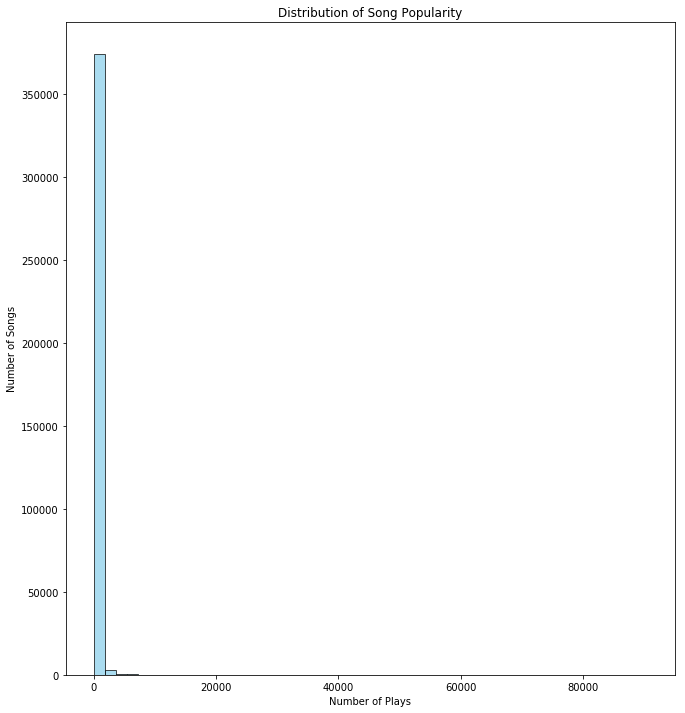

In [578]:
import matplotlib.pyplot as plt

# Counts of user plays per song
song_popularity = triplets_clean.groupBy("song_id").count().select("count").rdd.flatMap(lambda x: x).collect()

# Counts of song plays per user
#user_activity = triplets_clean.groupBy("user_id").count().select("count").rdd.flatMap(lambda x: x).collect()

# Plotting the distributions
plt.figure(figsize=(24, 12))

plt.subplot(1, 2, 1)
plt.hist(song_popularity, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Plays')
plt.ylabel('Number of Songs')
plt.title('Distribution of Song Popularity')

#plt.subplot(1, 2, 2)
#plt.hist(user_activity, bins=50, color='salmon', edgecolor='black', alpha=0.7)
#plt.xlabel('Number of Plays')
#plt.ylabel('Number of Users')
#plt.title('Distribution of User Activity')
#
#plt.tight_layout()
plt.show()

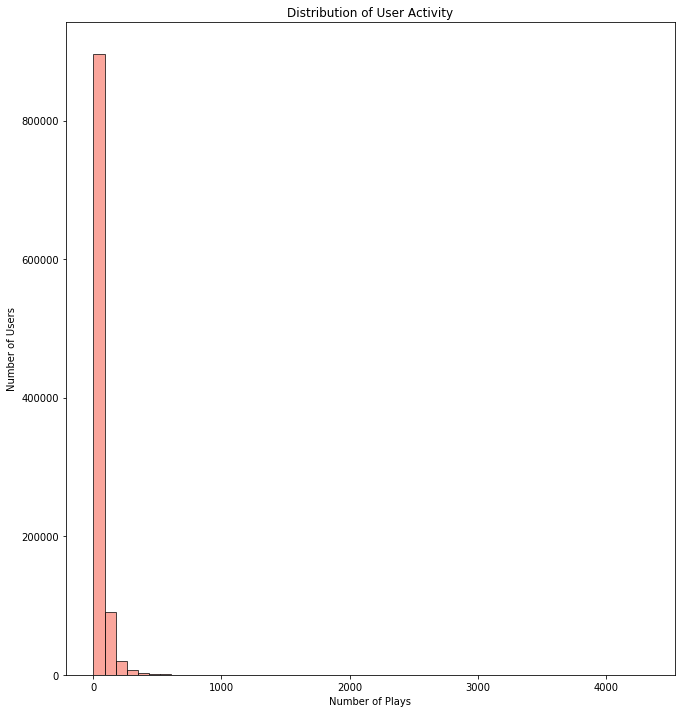

In [579]:
import matplotlib.pyplot as plt

# Counts of user plays per song
#song_popularity = triplets_clean.groupBy("song_id").count().select("count").rdd.flatMap(lambda x: x).collect()

# Counts of song plays per user
user_activity = triplets_clean.groupBy("user_id").count().select("count").rdd.flatMap(lambda x: x).collect()

# Plotting the distributions
plt.figure(figsize=(24, 12))

#plt.subplot(1, 2, 1)
#plt.hist(song_popularity, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
#plt.xlabel('Number of Plays')
#plt.ylabel('Number of Songs')
#plt.title('Distribution of Song Popularity')

plt.subplot(1, 2, 2)
plt.hist(user_activity, bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Plays')
plt.ylabel('Number of Users')
plt.title('Distribution of User Activity')
#
#plt.tight_layout()
plt.show()

## Q2

### (a)

In [89]:
from pyspark.sql.functions import count

# Calculate the average number of songs users listen to
df = triplets_clean
avg_songs_per_user = df.groupBy("user_id").agg(count("song_id").alias("total_songs")) \
    .agg({"total_songs": "avg"}) \
    .collect()[0][0]

# Calculate the average user activity
avg_activity = df.groupBy("user_id").count() \
    .agg({"count": "avg"}) \
    .collect()[0][0]

# Print the results
print("Average songs per user:", avg_songs_per_user)
print("Average user activity:", avg_activity)

Average songs per user: 44.92719641956681
Average user activity: 44.92719641956681


#### assign N and M are 45 both

In [91]:
from pyspark.sql.functions import col

# Filter out songs played less than 45 times
filtered_songs = df.groupBy("song_id").count().filter(col("count") >= 45).select("song_id")

# Filter out users who listened to fewer than 45 songs
filtered_users = df.groupBy("user_id").count().filter(col("count") >= 45).select("user_id")

# Join the filtered dataframes to get the clean dataset
clean_dataset = df.join(filtered_songs, "song_id", "inner").join(filtered_users, "user_id", "inner")

# Show the cleaned dataset
clean_dataset.show()

+--------------------+------------------+-----+
|             user_id|           song_id|count|
+--------------------+------------------+-----+
|00fc9d7d12f74bcd9...|SOALSFW12AB0181774|   10|
|00fc9d7d12f74bcd9...|SOJKARY12A6701ED3F|   17|
|00fc9d7d12f74bcd9...|SOSYHME12A8C135DD8|    2|
|00fc9d7d12f74bcd9...|SOUFWEW12AB0180EB7|    4|
|00fc9d7d12f74bcd9...|SOCTUNF12A6701ED40|   17|
|00fc9d7d12f74bcd9...|SOAOVUU12AB0186929|    2|
|00fc9d7d12f74bcd9...|SOJPYXL12A8C13359C|    1|
|00fc9d7d12f74bcd9...|SORXQFP12A8C132F51|    1|
|00fc9d7d12f74bcd9...|SOYNJYG12AB0183176|    1|
|00fc9d7d12f74bcd9...|SOTMYHL12AAA8C666E|    2|
|00fc9d7d12f74bcd9...|SOHJOZQ12A67AE228A|    1|
|00fc9d7d12f74bcd9...|SOTOXBH12AAF3B5B96|    2|
|00fc9d7d12f74bcd9...|SOXPDMG12A6701F636|    7|
|00fc9d7d12f74bcd9...|SOVIYKB12A6D4F936B|   15|
|00fc9d7d12f74bcd9...|SOYASOM12A6D4F7DD2|    2|
|00fc9d7d12f74bcd9...|SOTVJAS12AF72A68E0|    1|
|00fc9d7d12f74bcd9...|SOCEOIL12A8C138B1B|    1|
|00fc9d7d12f74bcd9...|SOLLNTU12A6701CFDC

### (b)

In [92]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Calculate the total number of plays
total_plays = clean_dataset.count()

# Calculate the minimum number of plays per user for the test set
min_plays_per_user_test = int(total_plays * 0.25 / clean_dataset.select("user_id").distinct().count())

# Filter out users who have fewer than the minimum number of plays
windowSpec = Window.partitionBy("user_id")
filtered_dataset = clean_dataset.withColumn("user_plays", F.count("user_id").over(windowSpec))
filtered_dataset = filtered_dataset.filter(col("user_plays") >= min_plays_per_user_test)

# Randomly assign a rank to each row within each user's plays
filtered_dataset = filtered_dataset.withColumn("rank", F.row_number().over(windowSpec.orderBy(rand())))

# Filter the dataset to get the test set based on the rank
test_set = filtered_dataset.filter(col("rank") <= min_plays_per_user_test).drop("rank")

# Get the remaining rows as the training set
training_set = filtered_dataset.filter(col("rank") > min_plays_per_user_test).drop("rank")

# Show the final training and test sets
#training_set.show()
#training_seet.count()
#test_set.show()

In [93]:
training_set.show()
training_set.count()

+--------------------+------------------+-----+----------+
|             user_id|           song_id|count|user_plays|
+--------------------+------------------+-----+----------+
|00fc9d7d12f74bcd9...|SOXFYKH12AB017CE15|    5|        56|
|00fc9d7d12f74bcd9...|SOCTUNF12A6701ED40|   17|        56|
|00fc9d7d12f74bcd9...|SOIPCGZ12A8C13C805|    1|        56|
|00fc9d7d12f74bcd9...|SOVIYKB12A6D4F936B|   15|        56|
|00fc9d7d12f74bcd9...|SOZDGEW12A8C13E748|    1|        56|
|00fc9d7d12f74bcd9...|SORXQFP12A8C132F51|    1|        56|
|00fc9d7d12f74bcd9...|SOXPDMG12A6701F636|    7|        56|
|00fc9d7d12f74bcd9...|SOPQLBY12A6310E992|    2|        56|
|00fc9d7d12f74bcd9...|SOYIPFY12A8C13AF8C|    2|        56|
|00fc9d7d12f74bcd9...|SOYASOM12A6D4F7DD2|    2|        56|
|00fc9d7d12f74bcd9...|SOEXEKS12AB017BF4A|    1|        56|
|00fc9d7d12f74bcd9...|SOLLNTU12A6701CFDC|    1|        56|
|00fc9d7d12f74bcd9...|SOYNJYG12AB0183176|    1|        56|
|00fc9d7d12f74bcd9...|SOLRZTD12A81C23216|    2|        5

21651588

In [94]:
test_set.show(truncate = False)
test_set.count()

+----------------------------------------+------------------+-----+----------+
|user_id                                 |song_id           |count|user_plays|
+----------------------------------------+------------------+-----+----------+
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SOIDEJQ12AB01888CD|5    |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SODFLZY12AB0185DD9|2    |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SOZLDVG12A6701ED42|14   |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SONRETF12A6D4F9601|1    |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SOYASOM12A6D4F7DD2|2    |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SOCEOIL12A8C138B1B|1    |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SOZDGEW12A8C13E748|1    |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SOHNRJO12A8AE44A2B|10   |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SORXQFP12A8C132F51|1    |56        |
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|SOVRJXA12A

7016725

In [16]:
unique_users = test_set.select("user_id").distinct()
unique_users.show(truncate = False)


+----------------------------------------+
|user_id                                 |
+----------------------------------------+
|00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7|
|01993743eeabc8ad86be03c3c4e1d079d47403a7|
|01c773a6f60fa71d2e68d6b13f4ce258973b3204|
|023fbd425c7d0290d5131c7c1b5e22348035bec8|
|024c7ec842474b99daaaa5c1a3bafb6de37a55df|
|024df2ade4b84f8dedcf5d8064b7acd00675ab73|
|0290c889181f0855712054368ebf6fb167e7b5fc|
|02bcc0fdb9ee353f19f9ae37275fc15be8c33990|
|02bdc70fad56061416029198f2df072a80275b98|
|02fa1482e32b4350a09bcfcf4c82a7d93c113616|
|0301d3c1b2e4be83320a26ac3a85625f1c5bf8e7|
|032981dd591ad83ecf68ca1b72752b013b38a5f2|
|03394c06a42befc9805c596b7f0e4a088cd5f3b8|
|03999591cca35cbcaa203e42b852b69eb7d4ed0e|
|03bb46c9d0abf2b23971fb3bbc7106650eef2d7e|
|03c1f7ad34b45dd4bfc920dfcb8a5e55cf243a47|
|03c79574408175099e91883eb25b46f07b1f17b6|
|03cdc98fe3f14c82d2c4a0dd8d8f8d78776f87d6|
|03f7658af022543ca7da29200c3bb354ddc6b3fd|
|03fd3e0e76a9cb92608a6c8bd99698c54a8d2f72|
+----------

In [648]:
test_set.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- rating: integer (nullable = true)



### (c)

In [95]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# Convert the dataset to the required format for ALS
training_set = training_set.select(col("user_id"), col("song_id"), col("count").cast(IntegerType()).alias("rating"))
test_set = test_set.select(col("user_id"), col("song_id"), col("count").cast(IntegerType()).alias("rating"))

# Index the user_id column
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
song_indexer = StringIndexer(inputCol="song_id", outputCol="song_index")

# Create a pipeline to chain the indexers
pipeline = Pipeline(stages=[user_indexer, song_indexer])
als_data_indexed = pipeline.fit(training_set).transform(training_set)


# Create ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="user_index", itemCol="song_index", ratingCol="rating",
          implicitPrefs=True)

# Train the ALS model on the training data
model = als.fit(als_data_indexed)


In [96]:
test_set = pipeline.fit(test_set).transform(test_set)

### (d)

In [25]:
# Optionally, you can make recommendations for a specific user
user_id = "00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7"
user_index = als_data_indexed.select("user_id", "user_index").where(col("user_id") == user_id).select("user_index").collect()[0]["user_index"]
user_recs = model.recommendForUserSubset(spark.createDataFrame([[user_index]], ["user_index"]), 10)

# Show the recommendations for the user
user_recs.show(truncate = False)

+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                                                                                                              |
+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|215055    |[{302, 0.17962502}, {284, 0.17433491}, {202, 0.17354643}, {159, 0.17353362}, {100, 0.17220354}, {62, 0.17100047}, {197, 0.15731741}, {370, 0.15507421}, {195, 0.15456992}, {191, 0.15350719}]|
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [61]:
check1 = test_set.filter(col("user_id") == "00fc9d7d12f74bcd93fa787cc26a9c61a0904ac7")
check1.count()

23

In [62]:
check1.show(25)

+--------------------+------------------+-----+----------+----------+----------+
|             user_id|           song_id|count|user_plays|user_index|song_index|
+--------------------+------------------+-----+----------+----------+----------+
|00fc9d7d12f74bcd9...|SOCTUNF12A6701ED40|   17|        56|    1172.0|   10694.0|
|00fc9d7d12f74bcd9...|SONRETF12A6D4F9601|    1|        56|    1172.0|   18267.0|
|00fc9d7d12f74bcd9...|SONFCZQ12A6701EA33|    1|        56|    1172.0|    3241.0|
|00fc9d7d12f74bcd9...|SOVRJXA12A6D4F9602|    1|        56|    1172.0|   58625.0|
|00fc9d7d12f74bcd9...|SOKLQRE12A58A7BB97|    2|        56|    1172.0|    2388.0|
|00fc9d7d12f74bcd9...|SOLLNTU12A6701CFDC|    1|        56|    1172.0|      38.0|
|00fc9d7d12f74bcd9...|SOEKKDE12A58A7C98B|    5|        56|    1172.0|   36818.0|
|00fc9d7d12f74bcd9...|SOWVRKJ12AB018A76B|    1|        56|    1172.0|   77708.0|
|00fc9d7d12f74bcd9...|SOYNJYG12AB0183176|    1|        56|    1172.0|   65678.0|
|00fc9d7d12f74bcd9...|SODADB

In [26]:
# Optionally, you can make recommendations for a specific user
user_id = "02bcc0fdb9ee353f19f9ae37275fc15be8c33990"
user_index = als_data_indexed.select("user_id", "user_index").where(col("user_id") == user_id).select("user_index").collect()[0]["user_index"]
user_recs = model.recommendForUserSubset(spark.createDataFrame([[user_index]], ["user_index"]), 10)

# Show the recommendations for the user
user_recs.show(truncate = False)

+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                                                                                          |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|264162    |[{6, 0.9220185}, {2, 0.89664453}, {3, 0.8946096}, {32, 0.87012964}, {45, 0.8265251}, {11, 0.824303}, {55, 0.7333761}, {8, 0.71263784}, {153, 0.6777165}, {20, 0.6433814}]|
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [58]:
#check = test_set.filter(col("user_id") == "02bcc0fdb9ee353f19f9ae37275fc15be8c33990")
#check.orderBy(col("count").desc())
check.count()

23

In [59]:
check.show(25)

+--------------------+------------------+-----+----------+----------+----------+
|             user_id|           song_id|count|user_plays|user_index|song_index|
+--------------------+------------------+-----+----------+----------+----------+
|02bcc0fdb9ee353f1...|SONHLJN12A81C2169B|    2|        47|    3226.0|     803.0|
|02bcc0fdb9ee353f1...|SOLRBSH12AB018AE7B|    5|        47|    3226.0|     433.0|
|02bcc0fdb9ee353f1...|SOPCAWX12A6D4F4770|    1|        47|    3226.0|    3442.0|
|02bcc0fdb9ee353f1...|SOUFTBI12AB0183F65|   37|        47|    3226.0|      33.0|
|02bcc0fdb9ee353f1...|SOASTSF12A8C1420B5|    1|        47|    3226.0|     896.0|
|02bcc0fdb9ee353f1...|SOMCMKG12A8C1347BF|    1|        47|    3226.0|     148.0|
|02bcc0fdb9ee353f1...|SOODUWK12A6D4F6675|    1|        47|    3226.0|    2261.0|
|02bcc0fdb9ee353f1...|SOHEMBB12A6701E907|    5|        47|    3226.0|     121.0|
|02bcc0fdb9ee353f1...|SOOFYTN12A6D4F9B35|    2|        47|    3226.0|      25.0|
|02bcc0fdb9ee353f1...|SOAXGD

In [97]:
test_set.show()

+--------------------+------------------+------+----------+----------+
|             user_id|           song_id|rating|user_index|song_index|
+--------------------+------------------+------+----------+----------+
|00fc9d7d12f74bcd9...|SOTMYHL12AAA8C666E|     2|    1172.0|    2380.0|
|00fc9d7d12f74bcd9...|SOCEOIL12A8C138B1B|     1|    1172.0|   44233.0|
|00fc9d7d12f74bcd9...|SOVRJXA12A6D4F9602|     1|    1172.0|   62887.0|
|00fc9d7d12f74bcd9...|SOZLDVG12A6701ED42|    14|    1172.0|   40084.0|
|00fc9d7d12f74bcd9...|SOHUUFD12A6701DBD7|     1|    1172.0|    1601.0|
|00fc9d7d12f74bcd9...|SOIPCGZ12A8C13C805|     1|    1172.0|    6799.0|
|00fc9d7d12f74bcd9...|SONZZWM12A6310D85D|    15|    1172.0|   10555.0|
|00fc9d7d12f74bcd9...|SOFLGFS12AB0180277|     5|    1172.0|   52178.0|
|00fc9d7d12f74bcd9...|SOHHALP12A6D4FB6A8|     9|    1172.0|     234.0|
|00fc9d7d12f74bcd9...|SODFLZY12AB0185DD9|     2|    1172.0|   16733.0|
|00fc9d7d12f74bcd9...|SOGWTME12A8C1402F6|    15|    1172.0|   12851.0|
|00fc9

### (e)

In [98]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.sql.functions import col, collect_list

# Initialize Spark session
#spark = SparkSession.builder.appName("RankingEvaluatorExample").getOrCreate()

# Example setup: create the test_set DataFrame
# Replace this with your actual DataFrame creation
# The DataFrame should have columns 'user_id', 'song_index', 'rating' (actual relevance)

# Ensure 'rating' column is of type double
test_set = test_set.withColumn("rating", col("rating").cast("double"))

# Prepare predictions DataFrame
# Ensure 'recommendations' and 'relevant' columns are arrays of the correct type
predictions = test_set.groupBy("user_index").agg(
    collect_list("song_index").alias("recommendations"),
    collect_list("rating").alias("relevant")
)

# Initialize RankingEvaluator with appropriate columns
evaluator2 = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

# Set the rank (k)
k = 10

# Evaluate Precision at K
precisionAtK = evaluator2.evaluate(predictions, {evaluator2.metricName: "precisionAtK", evaluator2.k: k})

# Evaluate MAP at K
mapAtK = evaluator2.evaluate(predictions, {evaluator2.metricName: "meanAveragePrecisionAtK", evaluator2.k: k})

# Evaluate NDCG at K
ndcgAtK = evaluator2.evaluate(predictions, {evaluator2.metricName: "ndcgAtK", evaluator2.k: k})

# Print the results
print(f'Precision @ {k}: {precisionAtK:.5f}')
print(f'MAP @ {k}: {mapAtK:.5f}')
print(f'NDCG @ {k}: {ndcgAtK:.5f}')


Precision @ 10: 0.00743
MAP @ 10: 0.00381
NDCG @ 10: 0.01007


In [112]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()